In [647]:
from utilsGeneral import UtilsGeneral
from utilsModel import UtilsModel
from utilsPlot import UtilsPlot
from utilsEncoded import UtilsEncoded
from KnapSack import KnapSack
from shallowNet.shallowNet import shallowNet, DenseTranspose
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import transforms
import math
import scipy.stats as stats
import collections
import matplotlib.cm as cm
import tensorflow as tf
import matplotlib.gridspec as gridspec
from numpy.ma import masked_array
from matplotlib import pyplot, transforms
from pathlib import Path
import shutil
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from decimal import Decimal
import collections
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random 
import pickle



In [4]:
knapSack = KnapSack("100_5_25_1")
utg = UtilsGeneral(knapSack)
utm = UtilsModel(utg)
utp = UtilsPlot(utilsGeneral = utg, utilsModel = utm)
ute = UtilsEncoded(utilsGeneral = utg, utilsModel = utm)
fitness_function = knapSack.Fitness
m = utg.restore_model_from_numpy("100_5_25_1Knapsack_Layer1\\100_5_25_1Knapsack")

Best Objective Value: 0


In [5]:
#tmptrain = utg.generate_training_set(100, 100)
tmptrain1, tmptrain = utg.load_datasets(1, 2)

In [6]:
set1 = utg.load_datasets(1)
model1, model2, model3, model4, model5, model6= utg.load_models(1,2, 3,4,5,6)

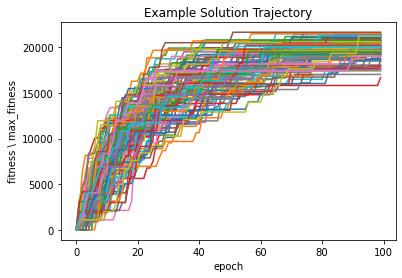

21634.0


In [237]:
max_fitness, final_solutions = utp.plot_trajectory_evolution(100, learning_steps = 100, sample_number=100, model = m)
print(max_fitness)

In [8]:
def TrainToSol(sol):
    ConvertSol = np.copy(sol)
    ConvertSol[sol == -1] = 0
    return ConvertSol

def SolDistribution(sol):
    size = np.shape(sol)[-1]
    arr = np.zeros(size)
    for i in sol:
        arr += TrainToSol(i)
    return arr/ np.shape(sol)[0]



def che(sol):
    arr = SolDistribution(sol)
    return AverageElements(arr)

In [9]:
def plot_distribution(sol, title = "Independent probability distribution", xl = "Bit position", yl ="Probability"):
    plt.figure()
    plt.title(title)
    plt.bar(np.arange(len(sol)), sol, align = "center", alpha = 0.5)
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.show()

In [6]:
def partition(array, numbers_of_partition=2, lambda_cof=1, mean= None, std = None):
    def get_index_list(array, element):
        return [i for i, e in enumerate(array) if e == element]
    if type(array) != type([1,2]):
        array = array.tolist()
    if std == None:
        std = np.std(array)
    if mean == None:
        mean = np.sum(array)/np.shape(array)[0] ### idk why np.mean(...) does not work 
    arraycopy = copy.copy(array)
    res = []
    mapindex = {}
    stop = False
    for i in range(1,numbers_of_partition+1): 
        tmp_left = []
        tmp_right = []
        array_len = len(arraycopy)
        for j in range(array_len):
            element = arraycopy.pop(0)
            if mapindex.get(element) == None:
                    mapindex[element] = get_index_list(array, element)
            if i == numbers_of_partition:
                if element < mean:
                    tmp_left.append(mapindex[element].pop())
                else:
                    tmp_right.append(mapindex[element].pop())
            else:
                if element >= mean - i * std/lambda_cof and element <= mean:
                    tmp_left.append(mapindex[element].pop())
                    
                elif element >= mean and element <= mean + i * std/lambda_cof:
                    tmp_right.append(mapindex[element].pop())
                else:
                    arraycopy.append(element)
                
        res.insert(0, np.asarray(tmp_left))
        res.append(np.asarray(tmp_right))

    return res, mean, std

In [7]:
def choose_group():
    p = [0.2, 0.3, 0.3, 0.2]
    r = np.random.choice(np.arange(len(p)),1, p=p)[0]
    x = np.random.choice(np.arange(2),1, p = [0.2, 0.8])[0]
    length = len(p)
    if r+x>length-1:
        x-=1
    return r, r+x

def flip(solution, index_one, index_two):
    solution[index_one] *= -1
    solution[index_two] *= -1
    return

def search_function(array, par, choosing_group_function = None, debuge_variation=False):
    if choosing_group_function == None:
        choosing_group_function = choose_group
    i_one, i_two = choosing_group_function()
    par = par[0]

    group_one = par[i_one]
    group_two = par[i_two]

    if len(group_one) == 0 or len(group_two) == 0:
        utg.flip(array, 100)
        return
    index_one = np.random.randint(len(group_one))
    index_two = np.random.randint(len(group_two))

    if not debuge_variation:
        flip(array, group_one[index_one], group_two[index_two])
    else:
        print(array)
        print(i_one, ", ", i_two, " partition shape: ", np.shape(par))
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
        flip(array, group_one[index_one], group_two[index_two])
        print("index_one: ", index_one," -> " ,group_one[index_one], " = ", array[group_one[index_one]] )
        print("index_two: ", index_two," -> " ,group_two[index_two], " = ", array[group_two[index_two]] )
    

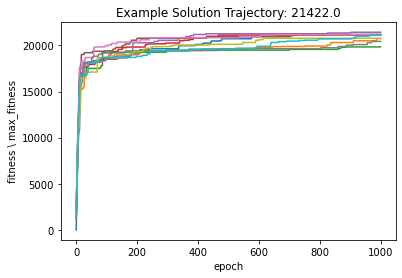

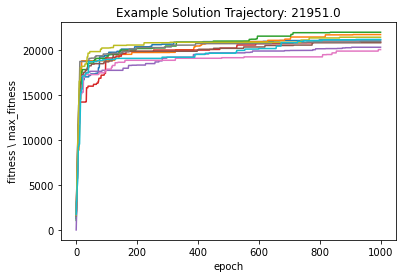

In [12]:
def plot_trajectory(sample_size, search = None, sample_number=10, learning_steps=100, transfer_step = 50, model=None, debuge_variation=False):
    global_solution = []
    par = []
    current_solutions_container = [utg.initialize_solution(sample_size) for i in range(sample_number)]
    max_fitness = 0
    for i in range(learning_steps):
        if i <transfer_step -1: 
            search = utg.flip
        else:
            if i % (transfer_step -1) == 0:
                par = partition(knapSack.P, numbers_of_partition=2, lambda_cof=1)    
        tmp_his = []
        for j in range(sample_number):
            copy_solution = copy.copy(current_solutions_container[j])
            if i > (transfer_step -1): 
                search_function(copy_solution, par = par, choosing_group_function = choose_group, debuge_variation = False)
            else:
                utg.flip(copy_solution, sample_size)
            current_fitness = fitness_function(current_solutions_container[j])
            new_fitness = fitness_function(copy_solution)
            if new_fitness > current_fitness:
                current_solutions_container[j] = copy_solution
                current_fitness = new_fitness
            tmp_his.append(current_fitness)
            if current_fitness >= max_fitness:
               max_fitness =current_fitness
            


        global_solution.append(np.asarray(tmp_his))
    global_solution = np.asarray(global_solution)
    plt.figure()
    plt.title("Example Solution Trajectory: {}".format(max_fitness))
    X = np.arange(learning_steps)
    for j in range(sample_number):
        plt.plot(X, global_solution[:,j])
    plt.xlabel("epoch")
    plt.ylabel("fitness \ max_fitness")
    plt.show()
        
    return global_solution, par
glob1, par1 = plot_trajectory(100, learning_steps= 1000, transfer_step = 100, model=m)
_ =plot_trajectory(100, learning_steps= 1000, transfer_step = 2000, model = m)


In [7]:
def code(array, encoder, input_size=None, latent_size=None, debuge_variation=False):
    """
    Code solution vector to the latent representation: 
    Parameters: 
        array - numpy ndarray to code 
        encoder - tf's model to encode 
    
    Optional Parameters: 
        input_size - size of the array
        latent_size - size of the latent space 
        debug_variation (False) - activate debug mode 
    """
    if input_size == None:
        input_size = len(array) # if input_size is implicit do not waist time to calcule it
    if latent_size == None:
        latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1] # if latent_size is implicit do not waist time to calcule it
    encoded_solution = encoder(np.expand_dims(array, axis = 0)).numpy().flatten() # encode array 
    return encoded_solution

def decod(encoded_solution, decoder, latent_size, output_size):

    """
    Decode solution from the latent representation to the input form. 
    Decoded solution is discretized [-1, 1] around 0.  
    
    Parameters: 
        encoded_solution - numpy ndarray to decode 
        encoder - tf's model to encode 
    
    Optional Parameters: 
        latent_size - size of the encoded_solution
        output_size - size of the decoded solutin
    """
    new_tensor = decoder(encoded_solution.reshape(1,latent_size)) # decode changed solution 
    output_array_binary = np.where(new_tensor.numpy()[-1] > 0.0, 1, -1)  # binarize decoded tensor around 0.0
    new_fitness = fitness_function(output_array_binary) # calculate new fitness
    return output_array_binary, new_fitness

In [9]:
def weights_matrix_sorting(model, activation=1, background_activation = -1, column_sort = True, unit_sort=True, index_sort = False, log_conversion = False):
    """
    Transofrm weight matrix for the sake of visibility. 

    Parameters: 
        model - tf's model from which weight matrix will be displayed 
    
    Optional Parameters:
        activation (1) - activation of a single bit 
        background_activation (-1) - activation of the remaining bits
        column_sort (True) -  sort weight by columns (True), sort weights by rows (False)
        unit_sort (True) - sort by the magnitude (absolut value) of weights (true), else sorth by signs (false)
        index_sort (False) - shuffle columns according to the probability of encoded neuron actiavtion (True)
        log_conversion (False) - convert values of weights to discrete log values (True), work on the linear scale (False)
    
    Returns:
        if unit_sort = True:
            return hidden_nodes_activation_distribution, weights_matrix, sorted_weights_matrix
        if unit_sort = False:
              return hidden_nodes_activation_distribution, weights_matrix, 
              negative_weights_negative_mask, positive_weights_negative_mask ,
              sorted_negative_weights_matrix, sorted_positive_weights_matrix
    """
    def extract_weight_matrix(weights):
        if type(weights) == type(np.array([[1],[1]])) and len(np.shape(weights))==2:
            return weights
        for w in weights:
            if(len(np.shape(w))==2):
                return w
    def value(x):
        if log_conversion:
            if x==0 or x ==-0:
                return 0
            return round(math.log(abs(x),10))
        else:
            if(x<0):
                return -x
            return x

    def shuffle_columns_weights_matrix(decoder, pos): 
        #matrix  = decoder.layers[1].get_weights()[1]
        matrix  = extract_weight_matrix(decoder.layers[1].get_weights())
        
        if np.shape(matrix)[0]< np.shape(matrix)[1]:
            matrix = matrix.transpose()
        mat = np.full_like(matrix, 0)
        index = 0
        for i in pos:
            mat[:, index] = matrix[:, i]
            index +=1
        return mat

    def matrix_row_sort(x):
        def pushZerosToEnd(arr): 
            count = 0 # Count of non-zero elements 
            n = len(arr)
            for i in range(n): 
                if arr[i] != 0: 
                    arr[count] = arr[i] 
                    count+=1
            while count < n: 
                arr[count] = 0
                count += 1
            return arr
        
        def pushZerosToBegining(arr): 
            count = 0 # Count of non-zero elements 
            tmp = []
            count_zeros =0
            for i in arr.tolist(): 
                if i != 0: 
                    tmp.append(i)
                else:
                    count_zeros+=1
            return np.concatenate((np.zeros(count_zeros), np.asarray(tmp)), axis = None)

        pos = []
        neg = []

        if unit_sort:
            for i in x:
                if i>0:
                    pos.append(value(i))
                else:
                    pos.append(value(-i))
            return np.sort(pos)

        else:
            for i in x:
                if i>0:
                    pos.append(value(i)) 
                    neg.append(0)
                else:
                    neg.append(value(-i))
                    pos.append(0)
            return pushZerosToEnd(-np.sort(-np.asarray(neg)[::-1])), pushZerosToBegining(np.sort(np.asarray(pos)))            
        
        
    encoder, decoder = utm.split_model_into_encoder_decoder(model)
    size = encoder.layers[0].input_shape[0][-1]
    latent_size = np.shape(encoder.layers[-1].get_weights()[0])[-1]
    res = np.zeros(latent_size)
    glob_pos = {}
    for i in range(size):
        arr = np.zeros(size) + background_activation
        arr[i] = activation
        res += np.where(code(arr, encoder) > 0.0, 0, 1)/size
    
    for i in range(latent_size):
        glob_pos[i] = res[i]

    if index_sort:
        pos = {k : v for k, v in sorted(glob_pos.items(), key = lambda item : item[1])}
        res.sort() # sort bits accorg
    else:
        pos = np.arange(latent_size)

    if column_sort:        
        weights_matrix = shuffle_columns_weights_matrix(decoder, pos).transpose()
    else:
        weights_matrix = shuffle_columns_weights_matrix(decoder, pos) 


    if unit_sort:
        sorted_weights_matrix = copy.copy(weights_matrix)
        for i in range(np.shape(sorted_weights_matrix)[0]):
            sorted_weights_matrix[i] = matrix_row_sort(sorted_weights_matrix[i])
        if column_sort:
            weights_matrix = weights_matrix.transpose()
            sorted_weights_matrix = sorted_weights_matrix.transpose()

        return res, weights_matrix, sorted_weights_matrix

    else:
        sorted_weights_matrix_neg = copy.copy(weights_matrix)
        sorted_weights_matrix_pos = copy.copy(weights_matrix)

        for i in range(np.shape(sorted_weights_matrix_pos)[0]):
            sorted_weights_matrix_neg[i], sorted_weights_matrix_pos[i] = matrix_row_sort(sorted_weights_matrix_neg[i])

        if column_sort:
            weights_matrix =weights_matrix.transpose()
            neg_mask = masked_array(sorted_weights_matrix_neg.transpose(), sorted_weights_matrix_neg.transpose()==0)
            pos_mask = masked_array(sorted_weights_matrix_pos.transpose(), sorted_weights_matrix_pos.transpose()==0)
        else: 
            neg_mask = masked_array(sorted_weights_matrix_neg, sorted_weights_matrix_neg==0)
            pos_mask = masked_array(sorted_weights_matrix_pos, sorted_weights_matrix_pos==0)

        return res, weights_matrix, neg_mask, pos_mask ,sorted_weights_matrix_neg, sorted_weights_matrix_pos

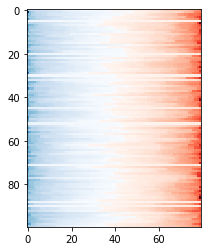

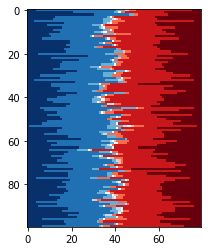

In [10]:
bit_activation, weights_matrix, neg_mask,pos_mask,_,_  = weights_matrix_sorting(m, activation=1, background_activation =-1, column_sort = False, unit_sort=False, index_sort = False, log_conversion = False)
plt.figure()
plt.imshow(neg_mask,interpolation='nearest',cmap=cm.Blues)
plt.imshow(pos_mask,interpolation='nearest',cmap=cm.Reds)
bit_activation, weights_matrix, neg_mask,pos_mask,_,_  = weights_matrix_sorting(model3, activation=1, background_activation =-1, column_sort = False,unit_sort=False, index_sort = False, log_conversion = True)
plt.figure()
plt.imshow(neg_mask,interpolation='nearest',cmap=cm.Blues)
plt.imshow(pos_mask,interpolation='nearest',cmap=cm.Reds)

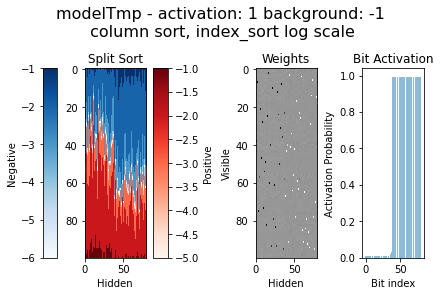

In [11]:
def latent_activation(model, title, activation=1, background_activation =-1, column_sort = True, unit_sort=True, index_sort = False, log_conversion = True):
    """
    Show plots associated with weight matrix measurements. 

    Parameters: 
        model - tf's model to evaluate 
        title - title to show on the plot title (advice - model name) as parameters will be added 
    
    Optional Parameters:
        activation (1) - activation of a single bit 
        background_activation (-1) - activation of the remaining bits
        column_sort (True) -  sort weight by columns (True), sort weights by rows (False)
        unit_sort (True) - sort by the magnitude (absolut value) of weights (true), else sorth by signs (false)
        index_sort (False) - shuffle columns according to the probability of encoded neuron actiavtion (True)
        log_conversion (False) - convert values of weights to discrete log values (True), work on the linear scale (False)
    
    Returns: 
        if index_sort True: 
            show plots of index_activation distribution, non sorted weight matrix, sorted weight matrix 
        if index_sort False: 
            show non sorted weight matrix, sorted weight matrix 
    """
    bit_activation, weights_matrix, *masks  = weights_matrix_sorting(model, activation, background_activation,column_sort = column_sort, unit_sort = unit_sort, index_sort = index_sort, log_conversion = log_conversion)

    title = title + " - activation: " +str(activation)+" background: "+ str(background_activation) + "\n "
    if column_sort:
        title += "column sort, "
    else:
        title += "row sort, "
    if index_sort:
        title += "index_sort"
    else:
        title += "no index sort"
    if log_conversion:
        title += " log scale"
    else:
        title += " linear scale"
    
    if index_sort:
        fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout = True)
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
    fig.suptitle(title, fontsize=16)
    if unit_sort:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Greys_r)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        cba.set_label('Magnitude of Absolute Activation')
        axes[0].set_title("Unit Sort")
        axes[0].set_xlabel("Hidden")
    else:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Blues)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        pb = axes[0].imshow(masks[1],interpolation='nearest',cmap=cm.Reds)
        cbb = fig.colorbar(pb, ax = axes[0], location = "right")
        cba.set_label('Negative')
        cbb.set_label('Positive')
        axes[0].set_title("Split Sort")
        axes[0].set_xlabel("Hidden")
    axes[0].set_aspect('auto')

    
    axes[1].imshow(weights_matrix, interpolation='nearest', cmap=cm.Greys_r)
    axes[1].set_title("Weights")
    axes[1].set_ylabel("Visible")
    axes[1].set_xlabel("Hidden")
    axes[1].set_aspect('auto')
    
    if index_sort:
        axes[2].bar(np.arange(len(bit_activation)), bit_activation, align = "center", alpha = 0.5)
        axes[2].set_title("Bit Activation")
        axes[2].set_ylabel("Activation Probability")
        axes[2].set_xlabel("Bit index")
        axes[2].set_aspect('auto')
    return fig, axes
fig, axes = latent_activation(model2, "modelTmp", background_activation=-1, unit_sort = False, index_sort=True, column_sort=True, log_conversion = True)

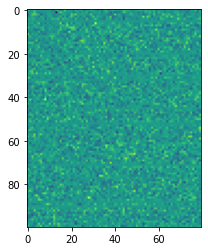

In [12]:
bit_activation, weights_matrix, *masks  = weights_matrix_sorting(m, activation=1, background_activation=-1,column_sort = True, unit_sort = True, index_sort = False)
plt.imshow(weights_matrix)

In [22]:
model = m
res, weights_matrix, neg_mask, pos_mask ,_,_  = weights_matrix_sorting(model, activation=1, background_activation =-1)
def plot_magnitude_weight(mask_neg, mask_pos):    
    v1a = mask_pos
    v1b = mask_neg
    fig,ax = plt.subplots()
    pa = ax.imshow(v1a,interpolation='nearest',cmap=cm.Reds)
    cba = plt.colorbar(pa)
    pb = ax.imshow(v1b,interpolation='nearest',cmap=cm.Blues)
    cbb = plt.colorbar(pb)
    plt.xlabel('Hidden', fontsize=14)
    plt.ylabel('Visible', fontsize=14)
    plt.title("Weights Matrix \nMagnitude Split Sort", fontsize=16)
    cba.set_label('Magnitude of Positive Activation')
    cbb.set_label('Magnitude of Negative Activation')
    plt.show()    
plot_magnitude_weight(neg_mask, pos_mask)

bit_activation, weights_matrix, sorted_weights_matrix  = weights_matrix_sorting(model, activation=1, background_activation =-1,)
plt.figure()
im = plt.imshow(sorted_weights_matrix, interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Magnitude of Absolute Activation')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix \n Magnitude Unit Sort", fontsize=16)

plt.figure()
im = plt.imshow(utm.split_model_into_encoder_decoder(model)[1].layers[1].get_weights()[1], interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Activation Value')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix", fontsize=16)

plt.figure()
im = plt.imshow(weights_matrix, interpolation='nearest',cmap=cm.Greys)
colb = plt.colorbar(im)
colb.set_label('Activation Value')
plt.xlabel("Hidden", fontsize =14)
plt.ylabel("Visible", fontsize=14)
plt.title("Weights Matrix Sorted", fontsize=16)

ValueError: not enough values to unpack (expected 6, got 3)

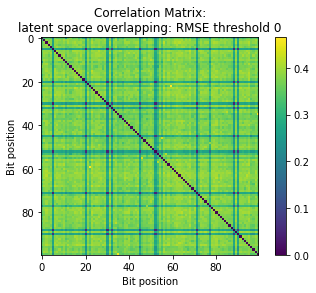

In [116]:
def correlation_matrix(model, activation=1, background_activation =-1, threshold = None):
    """
    Show "corellation" matrix. It compares encoded representation comming from 
    different single bits activation. "Correlation" is calculated as RMSE with 
    some threshodl value to alliviate noise influence. 

    Parameters: 
        model - tf's model to evaluet 
    
    Optional Parameters: 
        activation (1) - activation of a single bit 
        background_activation (-1) - activation of the remaining bits
        threshodle (None) - threshodl set to std, else threshold might be passed manually 
    
    Returns: 
        Corelation matrix plot 
    """
    def latent_activation(model):
        encoder, decoder = utm.split_model_into_encoder_decoder(model)
        size = encoder.layers[0].input_shape[0][-1]
        res = []
        for i in range(size):
            arr = np.zeros(size) + background_activation
            arr[i] = activation
            res.append(code(arr, encoder))
        return res

    def correlation(array1, array2, threshold = threshold):
        arr = array1-array2
        if threshold == None:
            threshold = np.std(arr)
        arr=np.where(((arr < threshold) & (arr > -threshold)), 0, arr)
        return np.sqrt((arr**2).mean())
  
   

    encoded_bit_representation =latent_activation(model)
    sample_numbers = np.shape(encoded_bit_representation)[0]
    conv = []
    for i in range(sample_numbers):
        tmp = []
        for j in range(sample_numbers):
            tmp.append(
                correlation(
                    encoded_bit_representation[i], 
                    encoded_bit_representation[j]
                    ))
        conv.append(np.asarray(tmp))
    return np.asarray(conv)

def plot_correlation_matrix(model, activation=1, background_activation =-1, threshold = None):
    plt.figure()
    res =correlation_matrix(model, activation=activation, background_activation = background_activation, threshold = threshold)
    plt.imshow(res, interpolation='nearest')
    if threshold==None:
        threshold = "std"
    plt.title("Correlation Matrix:\nlatent space overlapping: RMSE threshold {}".format(threshold))
    plt.xlabel("Bit position")
    plt.ylabel("Bit position")
    plt.colorbar()
    return plt

cor = plot_correlation_matrix(m, background_activation=-1, threshold = 0)




In [63]:
def cor_matrix(pos):
    l = len(pos)
    mat = np.zeros((l, 80, 100))
    for z in range(l):
        sample = pos[z]
        for x, v in sample.items():
            for y in v:
                mat[z][x][y] = 1
    return mat

def sample_change_distribution(e, d, sample, checks_per_sample):
    def non_zero_index_pos(arr):
        lis = []
        for i in range(len(arr)):
            if arr[i]!=0:
                lis.append(i)
        return lis
    pos = []
    fit = []
    for c in range(checks_per_sample):
        
        tmp = copy.copy(sample)
        tmp[c] *=-1
        encode = utm.code(tmp,e)
        decode_ref, decode_fit_ref = utm.decod(encode, d, len(encode), len(tmp))
        latent_size = len(encode)
        sample_size = len(tmp)
        dic_fit = {}
        dic_pos = {}
        for i in range(latent_size):
            encode_tmp = copy.copy(encode)
            encode_tmp[i] *=-1
            decode_tmp, decode_fit_tmp = utm.decod(encode_tmp, d, latent_size, sample_size)
            dic_fit[i] = decode_fit_tmp - decode_fit_ref
            dic_pos[i] = non_zero_index_pos(decode_tmp - tmp)
        pos.append(dic_pos)
        fit.append(dic_fit)
    return pos, fit


def foo(model, training_set, sample_numbers, checks_per_sample):

    mat=[]
    e,d = utm.split_model_into_encoder_decoder(model)

    for s in tqdm(range(sample_numbers)): 
        print(s) 
        pos, fit = sample_change_distribution(e,d, training_set[s], checks_per_sample)
        mat.append(cor_matrix(pos).mean(axis = 0))
    return np.asarray(mat), fit

mat, fit = foo(m, tmptrain2, 10, 10)


100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [8]:
def sample_change(e, d, sample):
    def non_zero_index_pos(arr):
        lis = []
        for i in range(len(arr)):
            if arr[i]==2:
                lis.append(i)
            if arr[i]==-2:
                lis.append(-i)
        return lis

    pos = []
    fit = []    
    encode = utm.code(sample,e)
    decode_ref, decode_fit_ref = utm.decod(encode, d, len(encode), len(sample))
    latent_size = len(encode)
    sample_size = len(sample)
    dic_fit = {}
    dic_pos = {}
    for i in range(latent_size):
        encode_tmp = copy.copy(encode)
        encode_tmp[i] *=-1
        decode_tmp, decode_fit_tmp = utm.decod(encode_tmp, d, latent_size, sample_size)
        dic_fit[i] = decode_fit_tmp - decode_fit_ref
        dic_pos[i] = non_zero_index_pos(decode_tmp - decode_ref)
    return dic_pos, dic_fit

def boo(model, training_set, sample_numbers, checks_per_sample):

    mat=[]
    fit = []
    e,d = utm.split_model_into_encoder_decoder(model)
    for s in tqdm(range(sample_numbers)): 
        pos, fit = sample_change_distribution(e,d, training_set[s], checks_per_sample)
        mat.append(pos)
    return np.asarray(mat), fit

In [9]:
def sample_change(e, d, sample):
    """
    Execute change in encoded space tracking changes in decode 
    form and in fitness. 
    """
    def changed_index_pos(arr):
        """
        Find position of changed bits in decoded representation. 
        Minus sign means addition of elements and positive signe
        means substraction
        """
        lis = []
        for i in range(len(arr)):
            if arr[i]==2:
                lis.append(i)
            if arr[i]==-2:
                lis.append(-i)
        return lis

    pos = []
    fit = []    
    encode = utm.code(sample,e)
    decode_ref, decode_fit_ref = utm.decod(encode, d, len(encode), len(sample))
    latent_size = len(encode)
    sample_size = len(sample)
    dic_fit = {}
    dic_pos = {}
    for i in range(latent_size):
        encode_tmp = copy.copy(encode)
        encode_tmp[i] *=-1
        decode_tmp, decode_fit_tmp = utm.decod(encode_tmp, d, latent_size, sample_size)
        dic_fit[i] = decode_fit_tmp - decode_fit_ref
        dic_pos[i] = changed_index_pos(decode_tmp - decode_ref)
    return dic_pos, dic_fit

def encoded_actions(p):

    def is_swap(arr):
        # check if bit change is a swap
        pos = False
        neg = False
        for i in arr: 
            if i > 0:
                pos = True
            if i<0: 
                neg = True
            if pos and neg: 
                return True
        return False
            
    single_add = {}
    swap = {}
    group = {}
    for k,v in p.items(): # split bit changes into separate groups
        if len(v) == 0: 
            continue
        if len(v)==1:
            single_add[k] = v
            continue
        if is_swap(v):
            swap[k] = v
        else:
            group[k] = v
    return swap, single_add, group 


def get_matrix_representation(dic, visible_size, hidden_size):
    """
    Convert bit chages into matrix to visualize
    """
    res = []
    for i in range(hidden_size):
        tmp = np.zeros(visible_size)
        if dic.__contains__(i):
            for k in dic[i]:
                if k<0:
                    tmp[-k] = -1
                else:
                    tmp[k] = 1
        res.append(tmp)

    return np.asarray(res)

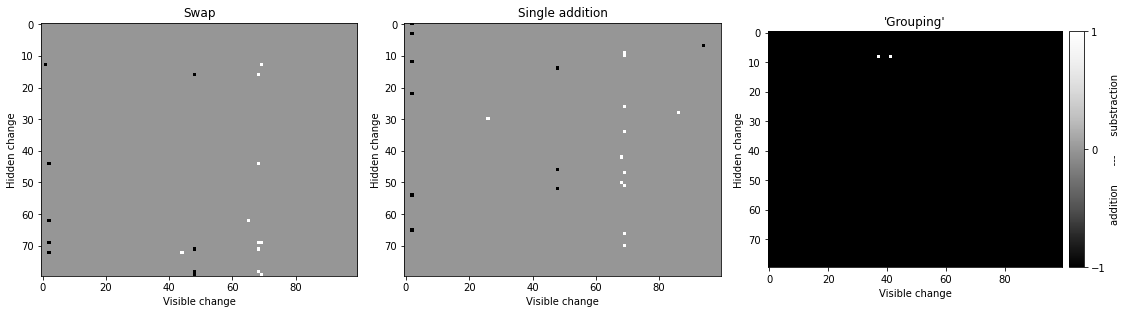

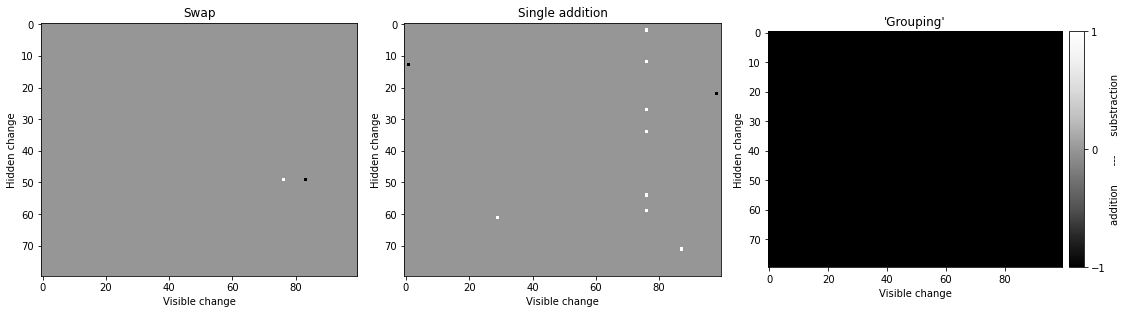

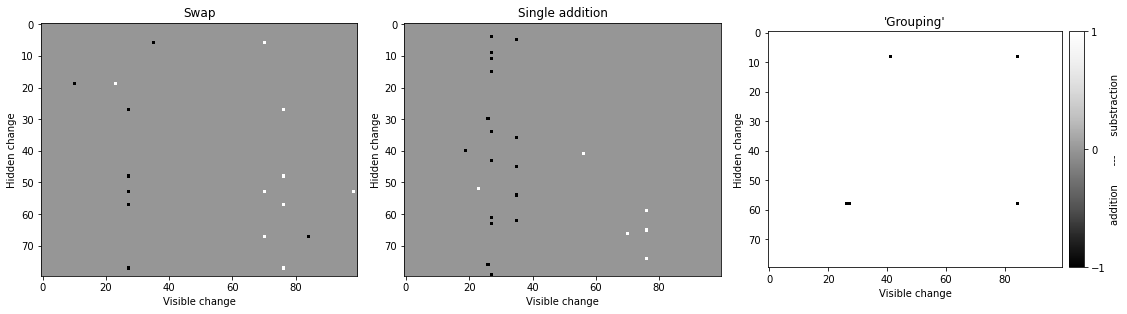

In [10]:


def show_actions_in_encoded_space(model, sample, show= True):
    """
    Visualize 
    """
    e,d = utm.split_model_into_encoder_decoder(model)
    visible_size = e.layers[0].input_shape[-1][-1]
    hidden_size = d.layers[0].input_shape[-1][-1]
    p, f = sample_change(e,d, sample)

    swap,single_add, group = encoded_actions(p)
    if show:
        fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout = True, figsize=(15,15))
        pc = axes[0].imshow(get_matrix_representation(swap, visible_size, hidden_size),interpolation='nearest',cmap=cm.Greys_r)
        axes[0].set_title("Swap")
        axes[0].set_xlabel("Visible change")
        axes[0].set_ylabel("Hidden change")

        axes[1].imshow(get_matrix_representation(single_add, visible_size, hidden_size),interpolation='nearest',cmap=cm.Greys_r)
        axes[1].set_title("Single addition")
        axes[1].set_xlabel("Visible change")
        axes[1].set_ylabel("Hidden change")

        axes[2].imshow(get_matrix_representation(group, visible_size, hidden_size),interpolation='nearest',cmap=cm.Greys_r)
        axes[2].set_title("'Grouping'")
        axes[2].set_xlabel("Visible change")
        axes[2].set_ylabel("Hidden change")
        divider = make_axes_locatable(plt.gca())
        cax = divider.append_axes("right", size="5%", pad=0.1)
        plt.colorbar(pc, cax=cax, ticks = [1,0,-1], label = "addition      ---      substraction")  
        plt.show()
    return p, f,swap ,single_add, group

_=show_actions_in_encoded_space(m, tmptrain[3])
_=show_actions_in_encoded_space(m, tmptrain[4])
tmp=show_actions_in_encoded_space(m, tmptrain[5], True)


In [240]:
def execute_encoded_changes(sample_set, size_set=500):
    swap = {}
    single_add = {}
    group = {}
    words = {}
    res = []
    for i in range(size_set):
        tmp = show_actions_in_encoded_space(m, sample_set[i], False)
        swap[i] = tmp[2]
        single_add[i] = tmp[3]
        group[i] = tmp[4]
        res.append(get_matrix_representation(tmp[2], 100,80))
        words[i] = tmptrain[i]
    return swap, single_add, group, words, res
swap, single_add, group, words, res = execute_encoded_changes(tmptrain, 2000)


In [674]:
swap[0]

{12: [-11, 78, -95], 30: [-11, 78], 41: [-11, 56], 69: [-4, 78]}

In [689]:
eval(str(list(np.asarray([-11, 78, -95])*(-1))))


[11, -78, 95]

In [698]:
def hash_function(array):
    return str(array)
def check_hash_function(array):
    return str(list(np.asarray(array)*(-1)))

def dehash(hash_code):
    return eval(hash_code)

In [711]:
print(hash_function([11, -78, 95]))
print(check_hash_function([11, -78, 95]))

[11, -78, 95]
[-11, 78, -95]


In [707]:
dic = {}
dic[1] = {}
dic[1][check_hash_function([11, -78, 95])]= 100
dic

{1: {'[-11, 78, -95]': 100}}

In [735]:
def hidden_vissible_genom_samples_map2(action_dic, hash_f, check_hash_f):
    res = {}
    for sn, hid in action_dic.items():
        for hid_change, vis_changes in hid.items():

            if not res.__contains__(hid_change):
                res[hid_change] = {}

            if not res[hid_change].__contains__(hash_f(vis_changes)) and  not res[hid_change].__contains__(check_hash_f(vis_changes)):
                    res[hid_change][hash_f(vis_changes)] = []

            if res[hid_change].__contains__(hash_f(vis_changes)):   
                res[hid_change][hash_f(vis_changes)].append(sn)
            if res[hid_change].__contains__(check_hash_f(vis_changes)):   
                res[hid_change][check_hash_f(vis_changes)].append(sn)

    return res
resswap = hidden_vissible_genom_samples_map2(swap, hash_function, check_hash_function)

In [833]:
resgroup = hidden_vissible_genom_samples_map2(group, hash_function, check_hash_function)

In [848]:
resgroup[13]

{'[-1, -75]': [7, 249, 292, 364, 584, 1221, 1451, 1452, 1778, 1809, 1827],
 '[-1, -87]': [11,
  233,
  288,
  505,
  796,
  1055,
  1097,
  1180,
  1228,
  1313,
  1481,
  1718,
  1781],
 '[1, 33]': [23, 33, 595, 637, 986, 1014, 1305, 1355, 1996],
 '[0, -1]': [24,
  162,
  466,
  533,
  881,
  995,
  1179,
  1303,
  1556,
  1631,
  1637,
  1713,
  1803,
  1973,
  1982],
 '[1, 38]': [28, 703, 1304, 1442, 1479],
 '[-1, -31]': [42,
  49,
  101,
  117,
  150,
  326,
  363,
  415,
  724,
  831,
  896,
  898,
  1018,
  1057,
  1311,
  1402,
  1457,
  1464,
  1529,
  1544,
  1956],
 '[-1, -31, -36, -38]': [52],
 '[1, 3]': [66],
 '[-42, -70]': [77],
 '[1, 9]': [78],
 '[-1, -24]': [81, 221, 1069, 1287, 1395, 1398, 1530, 1966],
 '[-1, -47]': [110, 372, 467, 527, 1034, 1211, 1271, 1425, 1616, 1745, 1795],
 '[-1, -46, -67]': [120],
 '[0, -33]': [126],
 '[1, 46]': [152,
  223,
  247,
  366,
  422,
  612,
  650,
  850,
  1198,
  1356,
  1522,
  1532,
  1780,
  1784],
 '[-1, -99]': [163, 293, 561, 64

In [616]:
def hidden_vissible_genom_samples_map(action_dic):
    res = {}
    for sn, hid in action_dic.items():
        for hid_change, vis_changes in hid.items():
            if not res.__contains__(hid_change):
                res[hid_change] = {}
            for vis_change in vis_changes:
                if not res[hid_change].__contains__(abs(vis_change)):
                    res[hid_change][abs(vis_change)] = []
                res[hid_change][abs(vis_change)].append(sn)
    return res
res = hidden_vissible_genom_samples_map(single_add)

In [655]:
def extract_genome(sample_set, args, show = False):
    """
    Calculate bits distribution based on given samples. 
    Parameters: 
        sample_set - traning set 
        args - list of indeces referring to the sample in sample_set
    Return: 
        np array of distribution of negative bits
    Optional: 
        show (False) - show graphicaly distributon
    """

    def AllPositivesToZero(sol):
        ConvertSol = np.copy(sol)
        return  np.where(sol > 0.0, 1, 0)
        
    def AllNegativesToZero(sol):
        ConvertSol = np.copy(sol)
        return np.where(sol > 0.0, 0, 1)    
    res_pos = []
    res_neg = []
    sample_size = len(sample_set[0])
    final_pos = np.zeros(sample_size)
    final_neg = np.zeros(sample_size)
    for i in args:
        res_pos.append(AllNegativesToZero(sample_set[i]))
        res_neg.append(AllPositivesToZero(sample_set[i]))
    final_pos = np.mean(np.asarray(res_pos), axis = 0)
    final_neg = np.mean(np.asarray(res_neg), axis = 0)
    mean = np.mean(final_pos)
    
    if show:
        plt.figure()
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        plt.bar(np.arange(len(final_pos)),-final_pos, color='blue', alpha = 0.7, label = "-p",transform = rot + base)
        plt.bar(range(len(final_neg)), -final_neg, bottom = -np.array(final_pos), color = "red", alpha = 0.7, label = "+p", transform = rot + base)
        plt.axvline(x = mean, color = "black", linestyle = '--')
        plt.title("Extracted genom")
        plt.xlabel("Probability")
        plt.ylabel("Bit positions")
        plt.legend()
        plt.show()
    return final_pos

#check_genom(ref, h, v, mean, number_of_samples = 10, threshold= 15000)[1]


In [607]:
def get_genome_from_distribution(distribution, coef=2,upper_limit = .98):
    """
    Extract genome from "negative" distribution. 
    Parameters: 
        distribution - distribution of negative values in solutions 
    Optional:
        coef (2) - coefficient standing next to std extracted from distribution
    Return 
        genome - np.array with -1 and 1 if they fall out of 2 * std and 0 else
    """
    std = np.std(distribution)
    mean = np.mean(distribution)
    if mean + coef*std >=1.0: 
        tmp = upper_limit
    else:
        tmp = mean + coef*std
    dist = np.where(distribution > tmp, -1, np.where(distribution < mean  - coef*std, 1, 0))
    return dist




In [648]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
save_obj(swap, "swap")

In [852]:
def get_genom_dist2(res, action, dehash_function, change_hash_function, len_coef = 5, number_of_samples = 100, sample_lenght_filter=10, std_coef = 2):
    result_acc = {}
    result_genom = {}
    result_len = {}
    progress_index = 0
    hid_len = len(res)
    for hid_change, visible_change in res.items():

        if not result_acc.__contains__(hid_change):
            result_acc[hid_change] = {}
        if not result_genom.__contains__(hid_change):
            result_genom[hid_change] = {}
        if not result_len.__contains__(hid_change):
            result_len[hid_change] = {}

        print(progress_index/ hid_len * 100, "%")
        progress_index +=1

        for vis_change, sample in visible_change.items():
            print(hid_change, " ", vis_change, " ", len(sample))

            if len(sample)>sample_lenght_filter:
                
                n= extract_genome(tmptrain, res[hid_change][vis_change], False)
                genom = get_genome_from_distribution(n, std_coef)
                result_len[hid_change][vis_change]= len(sample)
                result_genom[hid_change][vis_change] = genom
                result_acc[hid_change][vis_change] = check_genom(genom, hid_change, vis_change,action, dehash, check_hash_function, len_coef=len_coef, number_of_samples=number_of_samples)
            
    return result_acc, result_len, result_genom
a,l, g = get_genom_dist2(resgroup,2, dehash, check_hash_function, std_coef=2, sample_lenght_filter=5)

79, -86]   1
35   [-13, -24]   1
35   [-64, -89]   1
35   [-58, -69]   2
35   [-15, -82]   3
35   [-19, -73, -74, -89]   1
35   [-35, -85]   1
35   [-15, -19, -73, -82]   1
35   [-10, -24, -74]   1
35   [38, 96]   1
35   [0, 3]   1
35   [-38, -74]   2
35   [-15, -96]   1
35   [-19, -27]   1
35   [-13, -19, -73]   1
35   [-69, -86]   1
35   [-4, -93]   1
35   [-15, -27, -73, -89]   1
35   [-15, -70]   2
35   [-89, -94]   1
35   [-19, -73]   1
35   [-69, -79]   1
35   [-36, -93]   2
35   [-4, -58, -79]   1
35   [-69, -79, -80]   1
35   [-13, -19]   1
35   [-15, -73, -82]   1
35   [-8, -69, -80]   1
35   [-4, -72, -79]   1
35   [0, -15, -74, -99]   1
35   [-16, -70]   1
35   [-15, -38]   1
35   [-36, -79]   1
35   [-8, -80]   1
35   [-44, -74]   1
35   [-15, -73]   1
35   [0, -80]   1
35   [-57, -77]   1
35   [-15, -24, -82]   1
35   [-50, -69]   1
35   [-89, -99]   1
35   [-15, -55, -70]   1
35   [-19, -99]   1
35   [-36, -58, -83]   1
35   [-72, -83]   1
35   [-17, -99]   1
35   [-27, -

KeyboardInterrupt: 

In [749]:
def get_genom_dist(res,hidden_size, visible_size, len_coef = 5, number_of_samples = 100):
    result_acc = []
    result_genom = []
    result_len = []
    for h in range(hidden_size):
        res_row = []
        res_genom = []
        res_len = []
        print(h/hidden_size*100, "%")
        for v in range(visible_size):
            if res.__contains__(h) and res[h].__contains__(v):
                n,p = extract_genome(tmptrain, res[h][v], False)
                genom = get_genome_from_distribution(n, 2)
                res_len.append(len(res[h][v]))
                res_genom.append(genom)
                res_row.append(check_genom(genom, h, v, len_coef=len_coef, number_of_samples=100))
            else: 
                res_row.append(-1)
                res_len.append(0)
                res_genom.append(np.asarray([0]))

        result_acc.append(np.asarray(res_row))
        result_len.append(np.asarray(res_len))
        result_genom.append(np.asarray(res_genom))
    return np.asarray(result_acc), np.asarray(result_len), np.asarray(result_genom)

        
tmp = get_genom_dist(res, 2, 2,)



0.0 %
50.0 %


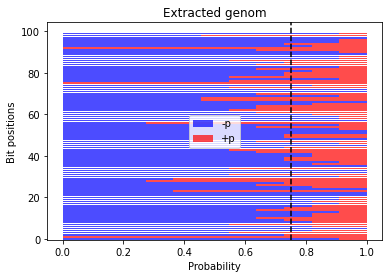

0.7499999999999999
fixed value


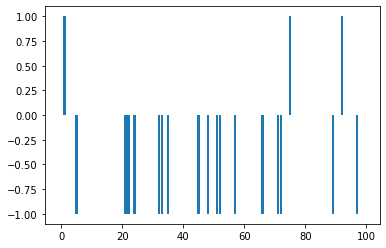

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
0.155


0.155

In [851]:
h = 13
v = '[-1, -75]'
n = extract_genome(tmptrain, resgroup[h][v], True)
genom = get_genome_from_distribution(n, 2)
plt.bar(np.arange(100), genom)
plt.show()
check_genom(genom, h, v,2,dehash, check_hash_function,number_of_samples=200, show= True, len_coef=5)



In [842]:
h = 13
v = '[-1, -31]'
print(resgroup[h][v])
counter = 0 
for i in resgroup[h][v]:
    dic = show_actions_in_encoded_space(m, tmptrain[i], False)[4]
    if dic[h]==dehash(v):
        counter+=1
    if dic[h] == dehash(check_hash_function(dehash(v))):
        counter +=1
    
counter/ len(resgroup[h][v])



[42, 49, 101, 117, 150, 326, 363, 415, 724, 831, 896, 898, 1018, 1057, 1311, 1402, 1457, 1464, 1529, 1544, 1956]


1.0

In [820]:
def check_genom(genom, hidden, visible, action, dehash, check_hash_f,len_coef=5, number_of_samples=100, show = False, ):
    counter = 0
    num = 0 
    const = int(number_of_samples/10)
    while num < number_of_samples:
        arr = get_sol_based_on_genom(genom, len_coef, False)
        num +=1
        dic = show_actions_in_encoded_space(m, arr, False)[2+action]
        if dic.__contains__(hidden) and (dic[hidden]==dehash(visible) or dic[hidden] == dehash(check_hash_function(dehash(visible)))):
            counter+=1
        if show and num % const==0:
            print(num/number_of_samples * 100, "%")

    print(counter/number_of_samples)

    return counter/number_of_samples


In [773]:
def get_sol_based_on_genom(genom, len_cof=10, show = False):
    sample_length = len(genom)
    genom_pos = []
    for i in range(sample_length): 
        if genom[i] != 0:
            genom_pos.append(i)
    flip_list = np.delete(np.arange(sample_length), genom_pos)
    current_solution = np.where(genom == 0, -1, genom)

    for i in range(len_cof * sample_length): 
        current_solution = flip_and_update(current_solution, search_genom,False, flip_list)
    if show: 
        print(fitness_function(current_solution))

    return current_solution


cur = get_sol_based_on_genom(genom, 5,show= True)





21100.0


In [574]:
def flip_and_update(current_solution, search, debuge_variation=False, *args):
    """
    Execute search function on the current_solution. 
    Update current_solution ifthe fitness value of 
    the modified solutin is greater, else does no change 
    
    Parameters:
        current_solution - container holding solution we modify 
        search - function searching and modyfing encoded representation 
    Optionals: 
        debug_variation (False) - turning on/off debug mode 
    Return: 
        conteiner, with the same type as current_solution
    """
    size = len(current_solution) # get the length of the solutin 
    rand_index = np.random.randint(size) # pick up a random index 
    new_solution = np.copy(current_solution) # copy current_solution 
    search(new_solution, *args) # execute search function on the copied solutino 
    new_fitness = fitness_function(new_solution, ) # calculate fitness of the new solution
    if new_fitness >= fitness_function(current_solution): 
        current_solution = new_solution # update current solutin if fitness is better 
    if debuge_variation: 
        print("New: ", new_fitness)
    return current_solution

In [582]:
def search_genom(solution, flip_list):
    index_one = random.choice(flip_list)
    index_two = random.choice(flip_list)
    solution[index_one] *=-1
    solution[index_two] *=-1
    return solution


In [569]:
for i in range(1000):
    

array([-1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [550]:
tmp = np. delete(np.arange(100), [0,1,99])
tmp

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98])

In [430]:
def check_genom2(genom, hidden, visible, mean,number_of_samples=100, threshold= 15000):
    counter = {}
    num = 0 
    while num < number_of_samples:
        arr = get_arr(genom, mean)
        
        if fitness_function(arr) > threshold :
            print(fitness_function(arr))
            num +=1
            dic = show_actions_in_encoded_space(m, arr, False)[3]

            for k,v in dic.items():
                v = abs(v[0])
                if not counter.__contains__(k):
                    counter[k] = {}
                if not counter[k].__contains__(v):
                    counter[k][v] = 0
                counter[k][v]+=1
    if not counter.__contains__(hidden) or not not counter[hidden].__contains__(visible):
        print("none")
        return None, None
    return counter, counter[hidden][visible]/number_of_samples



In [291]:
h = 3
v = 57
n,p = extract_genome(tmptrain, res[h][v], True)
ref, mean = get_genome_from_distribution(n, 1)
print(mean )
plt.bar(np.arange(100), ref)
plt.show()

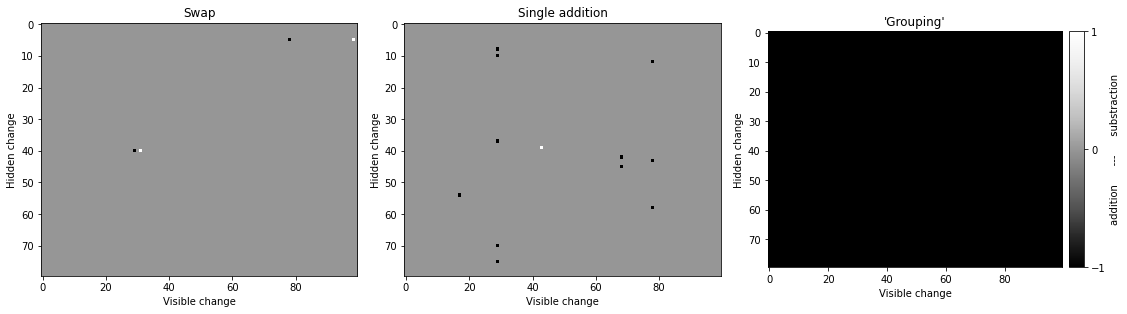

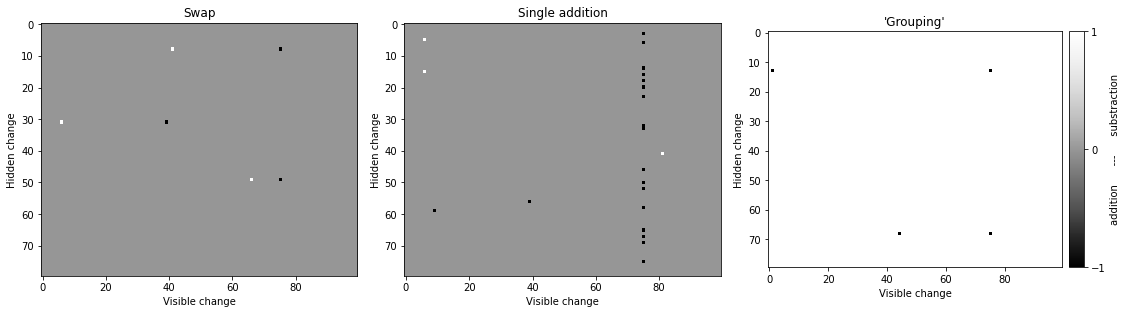

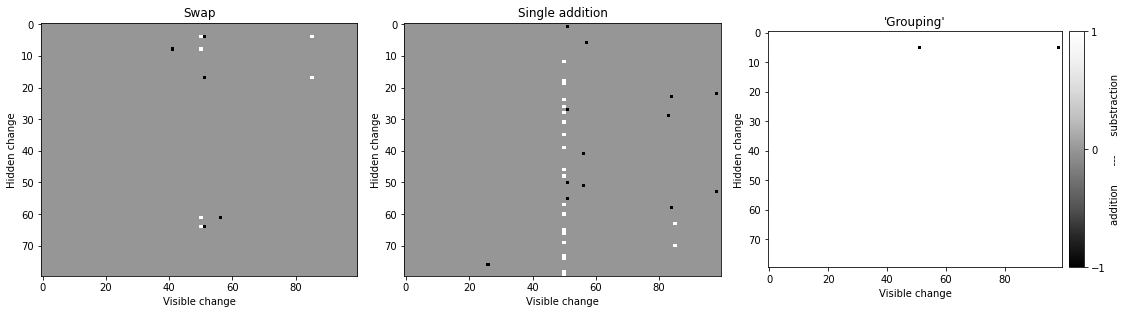

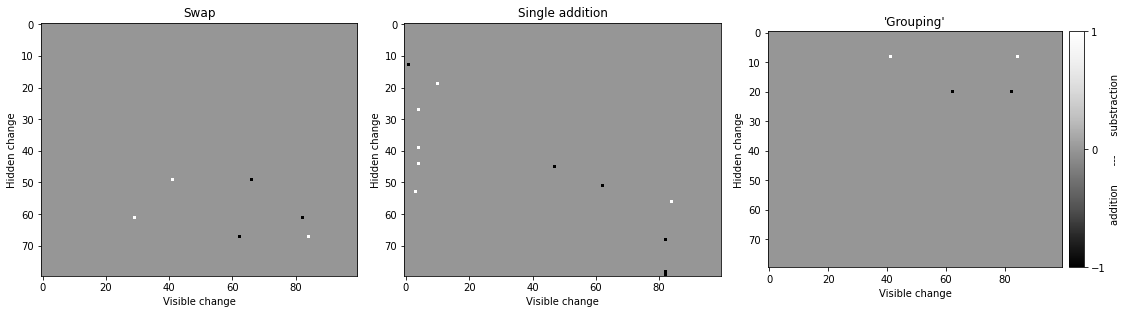

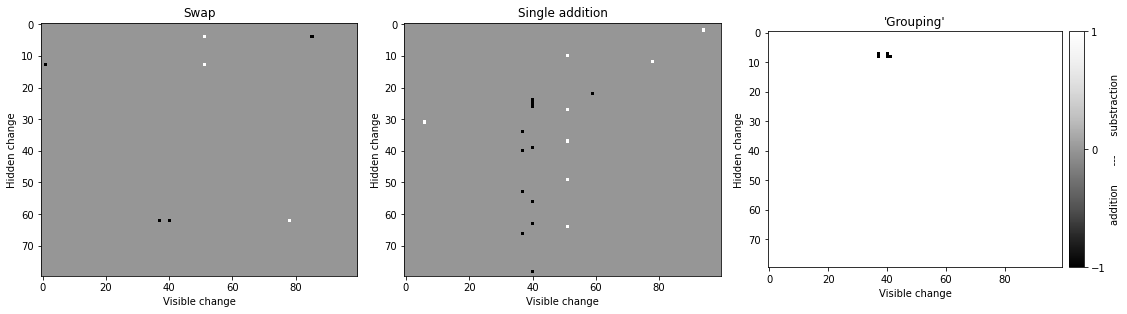

In [191]:
_=show_actions_in_encoded_space(m, tmptrain[6])
_=show_actions_in_encoded_space(m, tmptrain[7])
_=show_actions_in_encoded_space(m, tmptrain[8])
_=show_actions_in_encoded_space(m, tmptrain[9])
_=show_actions_in_encoded_space(m, tmptrain[10])

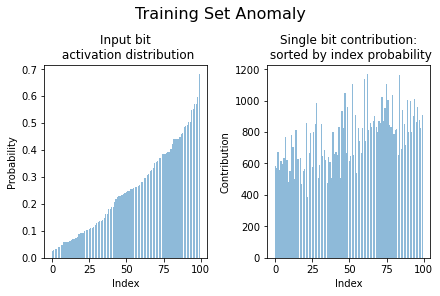

In [20]:
def plot_set_probability_and_values(set_):
    sample_size = np.shape(set_)[-1]
    arr = np.zeros(sample_size)
    set_size = np.shape(set_)[0]
    glob = {}
    index = 0
    for i in set_:
        arr +=np.where(i<0,0,1)
        
    arr = arr/set_size

    for i in range(len(arr)):
        glob[i] = arr[index]
        index +=1

    arr.sort()
    pos = {k : v for k, v in sorted(glob.items(), key = lambda item : item[1])}
    arr2 = []
    for i in pos:
        tmp = np.zeros(100)
        tmp[i] = 1
        arr2.append(np.dot(knapSack.P, tmp))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
    fig.suptitle('Training Set Anomaly', fontsize=16)
    axes[0].bar(np.arange(sample_size), arr, alpha = 0.5)
    axes[0].set_title("Input bit\n activation distribution")
    axes[0].set_ylabel("Probability")
    axes[0].set_xlabel("Index")
    axes[1].bar(np.arange(sample_size), arr2, alpha = 0.5) 
    axes[1].set_title("Single bit contribution:\n sorted by index probability")
    axes[1].set_ylabel("Contribution")
    axes[1].set_xlabel("Index")
    plt.show()
    return
    
plot_set_probability_and_values(tmptrain)

In [21]:
np.shape(tmptrain)

(4000, 100)

### EVERYTHING BELOW IS MY EXPERIMENTATION

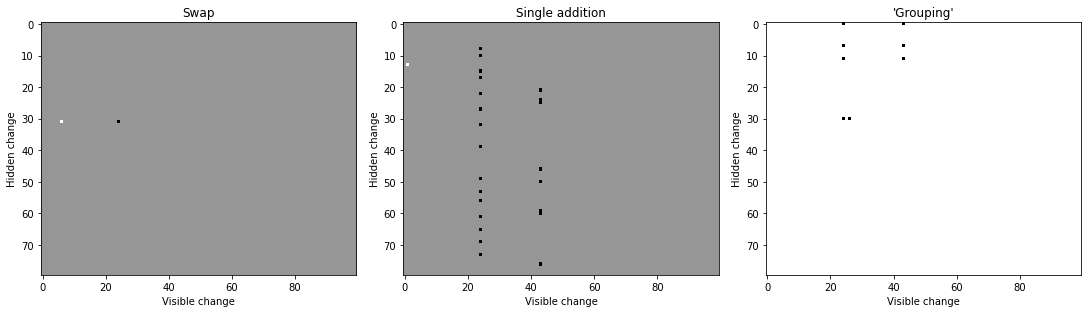

'\nr = encoded_flip_corelation_decoded(m, tmptrain2[5], knapSack.P, positive_fitness_dic_filter,True, True)\nr = encoded_flip_corelation_decoded(m, tmptrain2[6], knapSack.P, positive_fitness_dic_filter, True, True)\nr = encoded_flip_corelation_decoded(m, tmptrain2[7], knapSack.P, positive_fitness_dic_filter, True, True)\nr = encoded_flip_corelation_decoded(m, tmptrain2[8], knapSack.P, positive_fitness_dic_filter, True, True)\n'

In [199]:
def get_substracted_elements(e,d , sample, index):
    """
    code, make flip, decode -> check which bits were changed. 
    """
    encode = utm.code(sample,e)
    latent_size = len(encode)
    sample_size = len(sample)
    decode_ref, decode_fit_ref = utm.decod(encode, d, latent_size, sample_size)
    encode_tmp = copy.copy(encode)
    encode_tmp[index] *=-1
    decode_tmp, decode_fit_tmp = utm.decod(encode_tmp, d, latent_size, sample_size)
    visible_dif = decode_ref - decode_tmp

    subtract=[i for i,x in enumerate(visible_dif) if x > 0]

    return subtract

def find_nonzero_rows(res):
    non_zero_rows = []

    for row in range(len(res)):
        for col in res[row]:
            if col!=0:
                non_zero_rows.append(row)
                break
    return non_zero_rows


def inclusion_exclusion_covolutions(res, e,d, sample):
    active_rows = find_nonzero_rows(res)
    for r in active_rows:
        pos_to_neg = get_substracted_elements(e,d,sample, r)
        for i in pos_to_neg:
            res[r][i] = -1
    return res

def sample_changes(e, d, sample):
    def non_zero_index_pos(arr):
        lis = []
        for i in range(len(arr)):
            if arr[i]!=0:
                lis.append(i)
        return lis

    pos = []
    fit = []    
    encode = utm.code(sample,e)
    latent_size = len(encode)
    sample_size = len(sample)
    decode_ref, decode_fit_ref = utm.decod(encode, d, latent_size, sample_size)
    
    dic_fit = {}
    dic_pos = {}
    for i in range(latent_size):
        encode_tmp = copy.copy(encode)
        encode_tmp[i] *=-1
        decode_tmp, decode_fit_tmp = utm.decod(encode_tmp, d, latent_size, sample_size)
        dic_fit[i] = decode_fit_tmp - decode_fit_ref
        dic_pos[i] = non_zero_index_pos(decode_tmp - decode_ref)
    return dic_pos, dic_fit


def position_in_list(elem, lis):
    """
    returnn element positions in the list 
    """
    return [i for i,x in enumerate(lis) if x == elem]

def positive_fitness_dic_filter(f, max_elem = 1169):
    pos_dic = {}
    for k,v in f.items():
        if v >0 and abs(v) < max_elem :
            pos_dic[k] = v
    return pos_dic

def negative_fitness_dic_filter(f, max_elem = 1169):
    pos_dic = {}
    for k,v in f.items():
        if v < 0 and abs(v) < max_elem:
            pos_dic[k] = -v
    return pos_dic

def positive_negative_fitness_dic_filter(f):
    pos_dic = {}
    for k,v in f.items():
        if v != 0:
            pos_dic[k] = abs(v)
    return pos_dic


def encoded_swap_matrix(map_hidden_index_to_fitness, map_hidden_index_to_visible_index, independent_contribution_list, fitness_filter,show = False):
    """
    Show hidden and visible convolution. 
    """
    
    single_max_contrib = max(independent_contribution_list) # get maximal element
    result = [] 
    tmp = fitness_filter(map_hidden_index_to_fitness) # mapping: encoded_index --> positive fitnes contribution
    #tmp = map_hidden_index_to_fitness
    for j in range(len(map_hidden_index_to_visible_index)): # iterate over all possible encoded bits
        if j in tmp: # if this encoded index can contribute 
            contrib = map_hidden_index_to_fitness[j] #  value of contribution      
            res = np.zeros(100)
            contrib_position = position_in_list(abs(contrib), independent_contribution_list) # check if such contribution cannot come from element addition: list of elements with such contribution 
            if abs(contrib) < single_max_contrib and contrib_position == [] : # if it's a flip (the contrib_position is an empty list)
                for i in map_hidden_index_to_visible_index[j]: # mark changed bits according to the changed decoded bits comming from such encoded change 
                    res[i]=1
            result.append(res)
        else: # if this contribution come from addition of more elements mark nothing 
            result.append(np.zeros(100))
    
    return np.asarray(result)



def encoded_group_matrix(map_hidden_index_to_fitness, map_hidden_index_to_visible_index, independent_contribution_list, fitness_filter,show = False):
    """
    Show hidden and visible convolution. 
    """
    
    single_max_contrib = max(independent_contribution_list) # get maximal element
    result = [] 
    tmp = fitness_filter(map_hidden_index_to_fitness) # mapping: encoded_index --> positive fitnes contribution
    #tmp = map_hidden_index_to_fitness
    for j in range(len(map_hidden_index_to_visible_index)): # iterate over all possible encoded bits
        if j in tmp: # if this encoded index can contribute 
            contrib = map_hidden_index_to_fitness[j] #  value of contribution      
            res = np.zeros(100)
            if abs(contrib) > single_max_contrib: # if it's a flip (the contrib_position is an empty list)
                for i in map_hidden_index_to_visible_index[j]: # mark changed bits according to the changed decoded bits comming from such encoded change 
                    res[i]=1
            result.append(res)
        else: # if this contribution come from addition of more elements mark nothing 
            result.append(np.zeros(100))
    
    return np.asarray(result)

def encoded_single_add_matrix(map_hidden_index_to_fitness, map_hidden_index_to_visible_index, independent_contribution_list, fitness_filter,show = False):
    """
    Show hidden and visible convolution. 
    """
    
    single_max_contrib = max(independent_contribution_list) # get maximal element
    result = [] 
    tmp = fitness_filter(map_hidden_index_to_fitness) # mapping: encoded_index --> positive fitnes contribution
    #tmp = map_hidden_index_to_fitness
    for j in range(len(map_hidden_index_to_visible_index)): # iterate over all possible encoded bits
        if j in tmp: # if this encoded index can contribute 
            contrib = map_hidden_index_to_fitness[j] #  value of contribution      
            res = np.zeros(100)
            contrib_position = position_in_list(abs(contrib), independent_contribution_list) # check if such contribution cannot come from element addition: list of elements with such contribution 
            for i in contrib_position:
                res[i]=1
            result.append(res)
        else: # if this contribution come from addition of more elements mark nothing 
            result.append(np.zeros(100))
    
    return np.asarray(result)



def encoded_flip_corelation_decoded(model, sample, contrib_array, encoded_matrix_function,fitness_filter, show = False, inclusion_exclusion = True):
    e,d = utm.split_model_into_encoder_decoder(model)
    pos_map, fit_map = sample_changes(e,d,sample)
    independent_contribution_sample_list = contrib_array
    result = encoded_matrix_function(fit_map, pos_map, independent_contribution_sample_list, fitness_filter, show,)


    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout = True, figsize=(15,15))
    #fig.suptitle("Plots of changes in encoded space", fontsize = 16)

    result = encoded_swap_matrix(fit_map, pos_map, independent_contribution_sample_list, fitness_filter, show,)
    res_tmp = inclusion_exclusion_covolutions(result, e, d, sample)

    pa = axes[0].imshow(res_tmp,interpolation='nearest',cmap=cm.Greys_r)
    #cba = fig.colorbar(pa, ax = axes[0], location = "left")
    #cba.set_label('Magnitude of Absolute Activation')
    axes[0].set_title("Swap")
    axes[0].set_xlabel("Visible change")
    axes[0].set_ylabel("Hidden change")

    result = encoded_single_add_matrix(fit_map, pos_map, independent_contribution_sample_list, fitness_filter, show,)
    res_tmp = inclusion_exclusion_covolutions(result, e, d, sample)

    pb = axes[1].imshow(res_tmp,interpolation='nearest',cmap=cm.Greys_r)
    #cbb = fig.colorbar(pa, ax = axes[0], location = "left")
    #cbb.set_label('Magnitude of Absolute Activation2')
    axes[1].set_title("Single addition")
    axes[1].set_xlabel("Visible change")
    axes[1].set_ylabel("Hidden change")

    result = encoded_group_matrix(fit_map, pos_map, independent_contribution_sample_list, fitness_filter, show,)
    res_tmp = inclusion_exclusion_covolutions(result, e, d, sample)

    pc = axes[2].imshow(res_tmp,interpolation='nearest',cmap=cm.Greys_r)
    #cbc = fig.colorbar(pa, ax = axes[0], location = "left")
    #cbc.set_label('Magnitude of Absolute Activation3')
    axes[2].set_title("'Grouping'")
    axes[2].set_xlabel("Visible change")
    axes[2].set_ylabel("Hidden change")

    
    plt.show()

    return result

r = encoded_flip_corelation_decoded(m, tmptrain2[2], knapSack.P, encoded_swap_matrix, positive_negative_fitness_dic_filter,True, True)



"""
r = encoded_flip_corelation_decoded(m, tmptrain2[5], knapSack.P, positive_fitness_dic_filter,True, True)
r = encoded_flip_corelation_decoded(m, tmptrain2[6], knapSack.P, positive_fitness_dic_filter, True, True)
r = encoded_flip_corelation_decoded(m, tmptrain2[7], knapSack.P, positive_fitness_dic_filter, True, True)
r = encoded_flip_corelation_decoded(m, tmptrain2[8], knapSack.P, positive_fitness_dic_filter, True, True)
"""


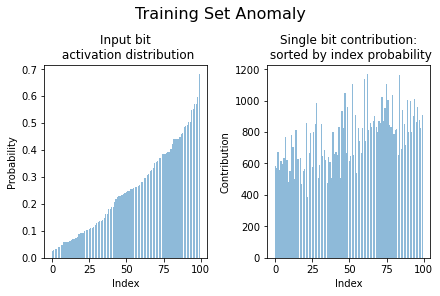

In [38]:
np.shape(tmptrain)

(10, 100)

In [15]:
def plot_latent_activation_distribution(set_, model, probability = False, sort = False, show = True, model_name = "", plot_name = None):
    def AllPositivesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return  np.where(sol > 0.0, 1, 0)
        ConvertSol[sol >= 0] = 0
        return ConvertSol
    def AllNegativesToZero(sol):
        ConvertSol = np.copy(sol)
        if probability:
            return np.where(sol > 0.0, 0, 1)
        ConvertSol[sol < 0] = 0
        return ConvertSol

    e, d= utm.split_model_into_encoder_decoder(model)
    res_pos = []
    res_neg = []
    latent_size = np.shape(e.layers[-1].get_weights()[0])[-1]
    final_pos = np.zeros(latent_size)
    final_neg = np.zeros(latent_size)
    for i in set_:
        res_pos.append(AllNegativesToZero(code(i,e)))
        res_neg.append(AllPositivesToZero(code(i,e)))
    for i in res_pos:
        final_pos += i
    for i in res_neg:
        final_neg += i

    final_pos = final_pos/len(set_)
    if probability:
        final_neg = final_neg/len(set_) 
    else: 
        final_neg = final_neg/len(set_) *(-1)

    if sort: 
        final_neg.sort()
        final_pos[::-1].sort()

    partition_, mean, std = partition(final_pos, numbers_of_partition=2)
    partition_size = len(partition_)
    std_lines = []
    set_lines = []
    for arr in partition_:
        set_lines.append(arr[-1])
    set_lines.pop(0)

    for i in range(1,int(partition_size/2)):
        std_lines.append(i*std + mean)
        std_lines.append(-i*std + mean)


    plt.figure()
    if probability:
        base = plt.gca().transData
        rot = transforms.Affine2D().rotate_deg(90)
        plt.bar(np.arange(len(final_pos)),-final_pos, color='blue', alpha = 0.7, label = "+p",transform = rot + base)
        plt.bar(range(len(final_neg)), -final_neg, bottom = -np.array(final_pos), color = "red", alpha = 0.7, label = "-p", transform = rot + base)
        #plt.gca().invert_xaxis()
        if sort:
            for xc in std_lines:
                plt.axvline(x = xc , color ="black", linestyle = '--')
            plt.axvline(x = mean, color = "black", linestyle = '--')
            for yc in set_lines: 
                plt.axhline(y = yc, color = "black", linestyle = '-')
            plt.title("+/-probability distributioin {}: stacked + sorted".format(model_name))
        else:
            plt.title("+/-probability distributioin {}: stacked".format(model_name))
        plt.xlabel("Probability")
        plt.ylabel("Bit positions")
        plt.legend()
    else:
        plt.bar(np.arange(len(final_pos)),final_pos,label = "Positive values", alpha = 0.5, color = "red")
        plt.bar(np.arange(len(final_neg)),final_neg, label = "Negative values * (-1)", alpha = 0.5, color = "blue")
        plt.title("+/- average bit values distributioin {}:".format(model_name))
        plt.ylabel("Average Value")
        plt.xlabel("Bit positions")
        plt.legend()
    if plot_name != None:
        path = utg.create_plot_path(plot_name)
        plt.savefig(path)
    return final_pos, final_neg, partition_

In [18]:
_ = plot_latent_activation_distribution(tmptrain, m, probability = True, sort = True, model_name = "model m")


NameError: name 'partition' is not defined

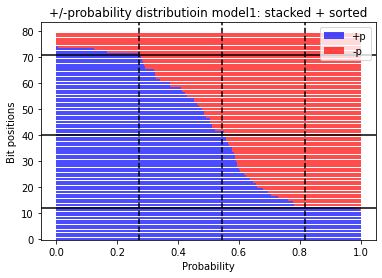

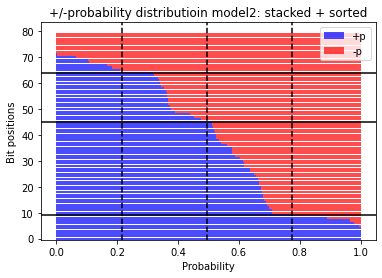

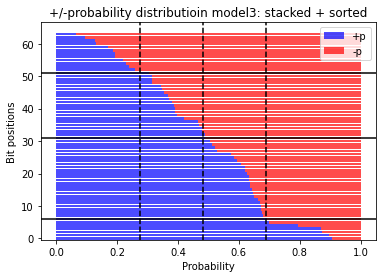

In [23]:
_ = plot_latent_activation_distribution(final_solutions, model1, probability = True, sort = True, model_name = "model1")
_ =plot_latent_activation_distribution(final_solutions, model2, probability = True, sort = True, model_name = "model2")
fp, fn, par  =plot_latent_activation_distribution(final_solutions, model3, probability = True, sort = True, model_name = "model3")
#fp, fn = plot_latent_activation_distribution(final_solutions, model3, probability = True, show= False, model_name = "model3")

In [48]:
def plot_histogram_value_contribution(model, activation_value = (1)):

    e, d= utm.split_model_into_encoder_decoder(model)
    size = np.shape(e.layers[-1].get_weights()[0])[-1]
    for activation in activation_value:
        
        result = []
        for i in range(size):
            tmp = np.zeros(size)
            tmp[i] = activation
            result.append(decod(tmp, d, size, knapSack.Size)[-1])
        result = np.asarray(result)
        plt.hist(result, bins = 100,  density=True, histtype='bar', stacked=True, alpha =0.5, label = "Activation: {}".format(activation))
    plt.legend()
    plt.title("Single bit's contribution distribution in latent space")
    plt.xlabel("Single bit contribution")
    axes = plt.gca()
    axes.set_xlim([14000,21000])
    plt.show()



In [26]:
def train_model(trainingSet, epochs = 500, compression = 0.8,  batch_size = 10, reg_cof = (0.0001,0.001), dropout = 0.2, lr = 0.001, validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError() ):
    modelTmp = shallowNet.build(
        input_shape=knapSack.Size, 
        reg_cof= reg_cof, 
        lr = lr, 
        dropout= dropout, 
        compression=compression, 
        metrics = metrics)

    H1 = modelTmp.fit(
        trainingSet, trainingSet, 
        validation_split = 0.1,
        epochs=epochs, 
        batch_size=batch_size, 
        shuffle=True,
        verbose=0)
    return modelTmp, H1

def plot(ax, model, plot_configuration):

    def convert_plot_option(opt):
        dic = {"column_sort": False, "unit_sort":False, "index_sort": False, "log_conversion": False}
        for i in opt: 
            if i == 'c':
                dic["column_sort"] = True
            if i == 'i':
                dic["index_sort"] = True
            if i == "u":
                dic["unit_sort"] = True
            if i == 'l':
                dic["log_conversion"] = True
        return dic

    kwargs = convert_plot_option(plot_configuration)

    bit_activation, weights_matrix, *masks  = weights_matrix_sorting(model, **kwargs)
    
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])

    if plot_configuration.__contains__('n'):
        ax.imshow(weights_matrix, interpolation='nearest',cmap=cm.Greys)
        return

    if kwargs.__contains__('unit_sort') and not kwargs['unit_sort']:
        pa = ax.imshow(masks[0],interpolation='nearest',cmap=cm.Blues)
        pb = ax.imshow(masks[1],interpolation='nearest',cmap=cm.Reds)    

    #if not kwargs.__contains__('column_sort'):
     #   ax.imshow(weights_matrix, interpolation='nearest',cmap=cm.Greys)

    ax.imshow(masks[0], interpolation='nearest',cmap=cm.Greys)



0  -  0  -  [0.001, 0.01]  -  0.001
0  -  1  -  [0.0001, 0.001]  -  0.001
0  -  2  -  [1e-05, 0.0001]  -  0.001
1  -  0  -  [0.001, 0.01]  -  0.0001
1  -  1  -  [0.0001, 0.001]  -  0.0001
1  -  2  -  [1e-05, 0.0001]  -  0.0001
saving  lr [0.001, 0.0001], reg [[0.001, 0.01], [0.0001, 0.001], [1e-05, 0.0001]],  epo 1, com 0.8, bat 20, dro 0.2, val 0.05, 
0  -  0  -  [0.001, 0.01]  -  0.001
0  -  1  -  [0.0001, 0.001]  -  0.001
0  -  2  -  [1e-05, 0.0001]  -  0.001
1  -  0  -  [0.001, 0.01]  -  0.0001
1  -  1  -  [0.0001, 0.001]  -  0.0001
1  -  2  -  [1e-05, 0.0001]  -  0.0001
saving  lr [0.001, 0.0001], reg [[0.001, 0.01], [0.0001, 0.001], [1e-05, 0.0001]],  epo 1, com 0.8, bat 20, dro 0.2, val 0.05, 


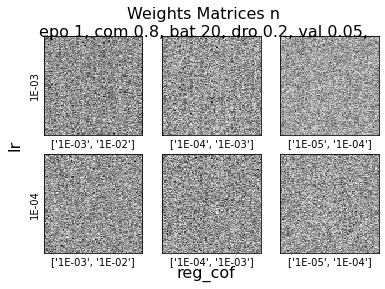

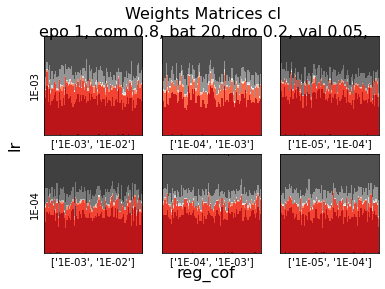

In [39]:
def hyper_params_tuner(training_function, visualize_function, vis_config=['n', "cl"], loss_funciton=None, correlation_function = None, **kwargs):
    """
    Hyperparameters tuning and ploting different weight matrxi from models. 
    Up to now it can handel two parameters tuning. 

    Params: 
        training_funciton - function to train model return model, training_history 
        visualize_funciton - function to show (plot) different models features: plot(ax, model, **kwargs)
        vis_config (["n", "cl"]) - list of configurations to plot: 
            c - column sort | if no c - row sort
            i - index sort | if no i - not index sort 
            u - unit sort | if no u - split sort 
            l - logarythmic conversion | if no l - linear scale
            n - no modified matrix (execute not modification of the matrix - pure weight matrix) 
            Example: 
            "ciul" - column sort + index_sort + unit sort + logarythmic conversion 
            "l" - raw sort + no index sort + split sort + logarythmic conversion 
            "n" - raw weight matrix

        Important !!!!    
        **kwargs - list of arguments with names to execute training_function.
            Important!!! - we can pass many arguments to one parameter as it 
            would be examied in the hyper_parameters tunning. 

            Example:  trainingSet = tmptrain, epochs = 1, compression = 0.8, 
                       batch_size = 20, reg_cof = [[0.001,0.01],[0.0001,0.001],[0.00001,0.0001]], 
                       dropout = 0.2, lr = [0.001, 0.0001], validation_split = 0.05
            
            It will check and plot configuration of every reg_cof with every lr. 

            Plot is arranged in the following manner: 
                The bigges parameter variety is stretched horizontally
                The second bigges parameter variety is streched vertically. 
            Executing the **kwargs as in the example result in the gird plot with 
            reg_cof examined horizontally and lr examined vertically

    Params still to add: 
        loss_function - plot model's loss history 
        correltation_function - plot "correlation matrix" 

        
    """        
    def Perform(f, **kwargs):
        return f(**kwargs)

    def get_param_title(**kwargs):
        title = ""
        for k, v in kwargs.items():
            if k == "trainingSet":
                continue
            title += str(k[0:3])+" "+str(v)+", "
        return title

    def scientific_notation(x):
        if type(x)== list:
            tmp = []
            for i in x: 
                tmp.append('%.0E' % Decimal(i))
            return tmp
        return '%.0E' % Decimal(x)

    dic={}
    for key, value in kwargs.items():
            dic[key] = value
    var_params = {} 
    con_params = {}
    for k in sorted(dic, key = lambda k : 1 if(type(dic[k])==int or type(dic[k])==float) else len(dic[k])): 
        if(k =="trainingSet" or not type(dic[k]) == list):
            con_params[k]=dic[k]
        else: 
            var_params[k]= dic[k]
    size_arr = []
    for k, x in var_params.items():
        size_arr.append(len(x))
    
    for plot_option in vis_config:
        fig, axes = plt.subplots(nrows=size_arr[-2], ncols=size_arr[-1])
        fig.suptitle('Weights Matrices '+plot_option+' \n'+get_param_title(**con_params), fontsize=16)
        fig.subplots_adjust(hspace = .2, wspace = .2)
        pos = copy.copy(var_params)
        
        for minor_ax_key, minor_ax_value in pos.items(): 
            pos.pop(minor_ax_key)
            row = 0

            for minor_param in minor_ax_value: 
                for main_ax_key, main_ax_value in pos.items():
                    col = 0
                    for main_param in main_ax_value: 
                        con_params[main_ax_key] =main_param
                        con_params[minor_ax_key] = minor_param
                        print(row, " - ", col, " - ", main_param, " - ", minor_param)
                        
                        model, model_history = training_function(**con_params)
                        
                        visualize_function(axes[row][col], model, plot_option)     
                        if col == 0: 
                            axes[row][col].set_ylabel(scientific_notation(minor_param))
                        axes[row][col].set_xlabel(scientific_notation(main_param))
                        axes[row][col].set_aspect('auto')

                        col +=1
                    con_params.pop(main_ax_key)
                row +=1
                con_params.pop(minor_ax_key)           
            break
        fig.text(0.5, 0.04, list(var_params.keys())[1], ha='center', fontsize = 16)
        fig.text(0.04, 0.5,  list(var_params.keys())[0], va='center', rotation='vertical', fontsize = 16)
        fig.savefig(utg.create_plot_path("Plot {} for {} while {}.png".format(plot_option, get_param_title(**var_params), get_param_title(**con_params))))
        print("saving ", get_param_title(**var_params), get_param_title(**con_params))
        

hyper_params_tuner(train_model,plot, trainingSet = tmptrain, epochs = 1, compression = 0.8, batch_size = 20, reg_cof = [[0.001,0.01],[0.0001,0.001],[0.00001,0.0001]], dropout = 0.2 , lr = [0.001, 0.0001], validation_split = 0.05)

### EVERYTHING BELOW IS JUST MY EXPERIMENTATION

In [133]:
def paramRun(model_train_function, param_axis="reg_cof", weight_plot_options=[True, True, True], **kwargs):

    def name_dictionary(**kwargs):
        tmp = ""
        for key, value in kwargs.items():
            tmp +=str(key[0])+str(value[0])
        return tmp

    def name_model(**kwargs):
        tmp =""
        for key, value in kwargs.items():
            tmp+= key[0]+" "+str(value)+","
        print(tmp)
        return tmp


    dic={}
    for key, value in kwargs.items():
            dic[key] = value
    pos = {}
    for k in sorted(dic, key = lambda k : 1 if(type(dic[k])==int or type(dic[k])==float) else len(dic[k]), reverse= True): pos[k]=dic[k]
    print(pos)
   

    #param_dim = dic.pop(param_axis)
    dict_list = dic.items()
    #directory_name = name_dictionary(**kwargs)
    #directory_name = "experimentaldict"
    """
    for param_axis_value in param_dim:

        for key, value in dic.items():
            if type(value)==float or type(value)==int or len(value)==1:
                continue

            dic2 = copy.copy(dic)
            searching_param = dic2.pop(key)
            current_param_dict = {}
            current_param_dict[param_axis] = param_axis_value

            for i in searching_param:
                current_param_dict[key] = i
                current_param_dict.update(dic2)                
                name_model(**current_param_dict)
                #model, his = model_train_function(trainingSet, **current_param_dict)
                #save_model(model, his.history, directory_name, name_model(**current_param_dict))
    """
    return pos

def boo(**kwargs):
    tmp =""
    for key, value in kwargs.items():
        tmp+= key+str(value)+"-"
    return tmp


dic = paramRun(train_model, trainingSet = tmptrain, param_axis = "reg_cof", epochs = 1, compression = 0.8, batch_size = 20, reg_cof = [[0.001,0.01],[0.0001,0.001]], dropout = 0.2, lr = [0.001,0.1, 0.0001], validation_split = 0.05, )
dic


{'lr': [0.001, 0.1, 0.0001], 'reg_cof': [[0.001, 0.01], [0.0001, 0.001]], 'trainingSet': [array([[-1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
        -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
        -1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
         1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
         1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
        -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
         1.,  1.,  1., -1.,  1., -1., -1., -1., -1.],
       [-1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
        -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
        -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
         1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
        -1., -1.,  1., -1., -1., -1.,  1., -1., -1., 

{'lr': [0.001, 0.1, 0.0001],
 'reg_cof': [[0.001, 0.01], [0.0001, 0.001]],
 'trainingSet': [array([[-1., -1., -1.,  1., -1., -1., -1.,  1.,  1.,  1., -1., -1., -1.,
          -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
          -1., -1.,  1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
           1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
          -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
           1.,  1., -1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1., -1.,
          -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1.,
           1.,  1.,  1., -1.,  1., -1., -1., -1., -1.],
         [-1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1.,
          -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1.,
          -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1., -1., -1., -1.,
           1., -1.,  1.,  1.,  1., -1., -1., -1.,  1., -1.,  1., -1., -1.,
          -1., -1.,  1., -1.,

In [185]:

def convert_plot_option(opt = "ciul"):
    dic = {"column_sort": False, "unit_sort":False, "index_sort": False, "log_conversion": False}
    for i in opt: 
        if i == 'c':
            dic["column_sort"] = True
        if i == 'i':
            dic["index_sort"] = True
        if i == "u":
            dic["unit_sort"] = True
        if i == 'l':
            dic["log_conversion"] = True
    return dic


def visualize_models(plotting_function,model,**kwargs):
    return plotting_function(**kwargs)

def train_models(training_function=None, **kwargs):
    return training_function(**kwargs)

def boo(*args, **kwargs):
    tmp =""
    for value in args: 
        tmp += str(value) + " "
    for key, value in kwargs.items():
        tmp+= key+" "+str(value)+"-"
    
    print(tmp)
    return tmp

def boo2(**kwargs):
    tmp =""
    for key, value in kwargs.items():
        tmp+= key+" "+str(value)+"-"
    print("training model")
    print(tmp)
    return tmp


def Perform(f, *args, **kwargs):
    return f(*args, **kwargs)



#Perform(lambda: visualize_models( boo,  None,  compression = 0.1))
#Perform(lambda: train_models( boo2, epoch = 10, compression = 0.8))
_ = Perform(boo, True, epoch = 0.1, valid = 80)





True epoch 0.1-valid 80-


In [320]:
list(dic.keys())

['lr',
 'reg_cof',
 'trainingSet',
 'epochs',
 'compression',
 'batch_size',
 'dropout',
 'validation_split']

In [267]:
model, model_history = train_model(tmptrain)
e,d = utm.split_model_into_encoder_decoder(model)
def extract_weight_matrix(weights):
    for w in weights:
        if(len(np.shape(w))==2):
            return w

matrix  = extract_weight_matrix(d.layers[1].get_weights())
matrix

In [312]:
from decimal import Decimal
def scientific_notation(x):
    if type(x)== list:
        tmp = []
        for i in x: 
            tmp.append('%.0E' % Decimal(i))
        return tmp
    return '%.0E' % Decimal(x)
    
scientific_notation([0.001, 0.00001])

            

['1E-03', '1E-05']

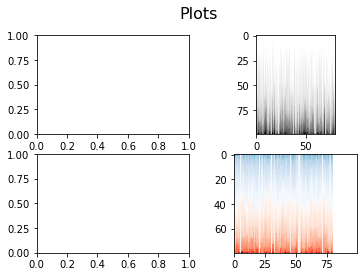

In [291]:
def plot(ax, model, **kwargs):
    tmp = {}
    for k,v in kwargs.items(): tmp[k]=v
    bit_activation, weights_matrix, *masks  = weights_matrix_sorting(model, **kwargs)
   
    if tmp.__contains__('unit_sort'):
        if not tmp['unit_sort']:
            
            pa = ax.imshow(masks[0],interpolation='nearest',cmap=cm.Blues)
            pb = ax.imshow(masks[1],interpolation='nearest',cmap=cm.Reds)
            return    
        
    if not tmp.__contains__('column_sort'):
        ax.imshow(weights_matrix, interpolation='nearest',cmap=cm.Greys)
        return 
    
    
    ax.imshow(masks[0], interpolation='nearest',cmap=cm.Greys)
    return


    axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle('Plots', fontsize=16)
fig.subplots_adjust(hspace = .2, wspace = 0.2)
plot(axes[0][1],model, unit_sort = True, column_sort = True, index_sort=False, log_conversion = False)
plot(axes[1][1], m, unit_sort = False)


In [287]:
type(tmptrain)

list

In [158]:
 title = title + " - activation: " +str(activation)+" background: "+ str(background_activation) + "\n "
    if column_sort:
        title += "column sort, "
    else:
        title += "row sort, "
    if index_sort:
        title += "index_sort"
    else:
        title += "no index sort"
    if log_conversion:
        title += " log scale"
    else:
        title += " linear scale"
    
    if index_sort:
        fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout = True)
    else:
        fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout = True)
    fig.suptitle(title, fontsize=16)
    if unit_sort:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Greys_r)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        cba.set_label('Magnitude of Absolute Activation')
        axes[0].set_title("Unit Sort")
        axes[0].set_xlabel("Hidden")
    else:
        pa = axes[0].imshow(masks[0],interpolation='nearest',cmap=cm.Blues)
        cba = fig.colorbar(pa, ax = axes[0], location = "left")
        pb = axes[0].imshow(masks[1],interpolation='nearest',cmap=cm.Reds)
        cbb = fig.colorbar(pb, ax = axes[0], location = "right")
        cba.set_label('Negative')
        cbb.set_label('Positive')
        axes[0].set_title("Split Sort")
        axes[0].set_xlabel("Hidden")
    axes[0].set_aspect('auto')

    
    axes[1].imshow(weights_matrix, interpolation='nearest', cmap=cm.Greys_r)
    axes[1].set_title("Weights")
    axes[1].set_ylabel("Visible")
    axes[1].set_xlabel("Hidden")
    axes[1].set_aspect('auto')
    
    if index_sort:
        axes[2].bar(np.arange(len(bit_activation)), bit_activation, align = "center", alpha = 0.5)
        axes[2].set_title("Bit Activation")
        axes[2].set_ylabel("Activation Probability")
        axes[2].set_xlabel("Bit index")
        axes[2].set_aspect('auto')
    return fig, axes

<module 'matplotlib.pyplot' from 'F:\\Anaconda\\envs\\myvenv\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [ ]:
def g(foo,):
    f( lambda: foo())



In [ ]:
def plots_hyper_parameters_tuning(size, ,**kwargs):

    param_name = "- com-"+str(compression)+" dro-"+str(dropout)+ " lr-"+str(lr)+" sort-"+weight_sort
    
    fig, axes = plt.subplots(nrows=size[0], ncols=size[1])
    fig.suptitle('Plots'+param_name, fontsize=16)
    fig.subplots_adjust(hspace = .2, wspace = 0.2)



    im = None
    im2=None
    imw = None
    for i in range(size[0]):

        for j in range(size[1]):
            model, model_history = model_train_function(
                trainingSet, **kwargs)

            #bit_activation, weights_matrix, sorted_weights_matrix = weights_matrix_sorting(model)
            if weight_sort=="unit":
                bit_activation, weights_matrix, sort_matrix = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(sort_matrix,interpolation='nearest',cmap=cm.Greys)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)
                

            if weight_sort=="split":
                bit_activation, weights_matrix, mask_neg, mask_pos, neg, pos = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(mask_neg,interpolation='nearest',cmap=cm.Blues)
                im2 = axes_sorted[i][j].imshow(mask_pos,interpolation='nearest',cmap=cm.Reds)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)


            axes_weight[i][j].set_aspect('auto')
            axes_weight[i][j].xaxis.set_ticks([])
            axes_weight[i][j].yaxis.set_ticks([])

            axes_sorted[i][j].set_aspect('auto')
            axes_sorted[i][j].xaxis.set_ticks([])
            axes_sorted[i][j].yaxis.set_ticks([])

            axes_index[i][j].bar(np.arange(len(bit_activation)), bit_activation)
            axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_index[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_loss[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_weight[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)


        l1value = round(math.log(reg_cof[0] / 10**i,10)    
        axes_sorted[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_index[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_loss[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_weight[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
    if weight_sort=="unit":
        
        fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])

    if weight_sort=="split":
        
        cbpos = fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
        cbneg = fig_sorted.colorbar(im2, ax=axes_sorted[:, order_variation-1])

    fig_weight.colorbar(imw, ax=axes_weight[:, order_variation-1])


        #plt.setp(axes_sorted[:,i], ylabel = "L1 {}".format(int(math.log(reg_cof[0] / 10**i,10)-1)))
    fig_sorted.text(0.5, 0.04, 'Hidden', ha='center', fontsize = 16)
    fig_sorted.text(0.04, 0.5, 'Visible', va='center', rotation='vertical', fontsize = 16)
    
    fig_index.text(0.5, 0.04, 'Index', ha='center', fontsize = 16)
    fig_index.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize = 16)
    
    fig_loss.text(0.5, 0.04, 'Epoch', ha='center', fontsize = 16)
    fig_loss.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize = 16)

    fig_sorted.savefig(utg.create_plot_path("Weights Sorted Comparision{}.png".format(param_name)))
    #fig_index.savefig(utg.create_plot_path("Index Sorted Comparision{}.png".format(param_name)))
    #fig_loss.savefig(utg.create_plot_path("Loss History Comparision{}.png".format(param_name)))
    fig_weight.savefig(utg.create_plot_path("Weights Comparision{}.png".format(param_name)))


In [212]:
def convert_plot_option(opt = "ciul"):
    dic = {"column_sort": False, "unit_sort":True, "index_sort": False, "log_conversion": False}
    for i in opt: 
        if i == 'c':
            dic["column_sort"] = True
        if i == 'i':
            dic["index_sort"] = True
        if i == "u":
            dic["unit_sort"] = True
        if i == 'l':
            dic["log_conversion"] = True
    return dic

In [30]:
def name_dictionary(**kwargs):
    tmp = ""
    for key, value in kwargs.items():
        tmp +=str(key)+str(value)+ ", "
    print(tmp)
    return 




In [81]:
str([[1,2],[3,4]])

'[[1, 2], [3, 4]]'

In [62]:


foo(epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [[0.001,0.01],[0.0001,0.001]], dropout = 0.2, lr = [0.001,999], validation_split = 0.05)

'e500c0.8b20r[[0.001, 0.01], [0.0001, 0.001]]d0.2l[0.001, 999]v0.05'

In [63]:
def save_model(model, model_history, directory, model_name, main_directory = "saved_models"):
    """
    Save model in the directory saved_model. 
    The model will not be saved if it's alreday saved. 
    
    Parameters: 
        model - TF's model 
    
    """
    
    model_dir = os.path.join(main_directory, directory, model_name)  # model dir
    model_path = Path(model_dir)  # model path
    
    # create model dir or if it's empty clean it
    try:
        model_path.rmdir()
    except OSError as e:
        print(f"Error: {model_path} : {e.strerror}")
    model_path.mkdir(exist_ok=True, parents=True)

    model.save(model_dir)
    if os.path.exists(model_path):
        shutil.rmtree(model_path)
    os.makedirs(model_path)
    model.save(model_path)
    np.save(os.path.join(main_directory, directory, model_name, 'model_history.npy'), model_history) 

    print("[INFO]: Model saved: ",model_dir)

save_model(model3, {"key":1}, foo(epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [[0.001,0.01],[0.0001,0.001]], dropout = 0.2, lr = [0.001,999], validation_split = 0.05), "exampleModelToDelete2")


Error: saved_models\e500c0.8b20r[[0.001, 0.01], [0.0001, 0.001]]d0.2l[0.001, 999]v0.05\exampleModelToDelete2 : The directory is not empty
INFO:tensorflow:Assets written to: saved_models\e500c0.8b20r[[0.001, 0.01], [0.0001, 0.001]]d0.2l[0.001, 999]v0.05\exampleModelToDelete2\assets
INFO:tensorflow:Assets written to: saved_models\e500c0.8b20r[[0.001, 0.01], [0.0001, 0.001]]d0.2l[0.001, 999]v0.05\exampleModelToDelete2\assets
[INFO]: Model saved:  saved_models\e500c0.8b20r[[0.001, 0.01], [0.0001, 0.001]]d0.2l[0.001, 999]v0.05\exampleModelToDelete2


In [397]:
def f(**kwargs):
    for key, value in kwargs.items():
        print(key, value)

f(mod1 = model, mod2 = model2)


mod1 <tensorflow.python.keras.engine.training.Model object at 0x00000210AB86B288>
mod2 <tensorflow.python.keras.engine.training.Model object at 0x00000210AB86B288>


In [485]:
save_model(model2, None, "experimentalModels", "exampleModel2")

Error: saved_models\experimentalModels\exampleModel2 : The directory is not empty
INFO:tensorflow:Assets written to: saved_models\experimentalModels\exampleModel2\assets
INFO:tensorflow:Assets written to: saved_models\experimentalModels\exampleModel2\assets
[INFO]: Model saved: directory-  experimentalModels , name:  exampleModel2


In [ ]:
def test_model(trainingSet, weight_plot_options=[True, True, False, False], epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.1, 0.1], dropout = 0.2, lr = 0.001, validation_split = 0.05):
    

In [326]:
#column_sort = True, unit_sort=True, index_sort = False, log_conversion = False


def test_model_reg_cof(trainingSet, model_train_function,  epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.1, 0.1], dropout = 0.2, lr = 0.001, validation_split = 0.05, weight_sort_options=[True, True, False, False], metrics = tf.keras.metrics.RootMeanSquaredError(),):
    param_name = "- com-"+str(compression)+" dro-"+str(dropout)+ " lr-"+str(lr)+" sort-"+weight_sort
    
    fig_sorted, axes_sorted = plt.subplots(nrows=order_variation, ncols=order_variation)
    fig_sorted.suptitle('Weights Matrices Magnitude Sort '+param_name, fontsize=16)
    fig_sorted.subplots_adjust(hspace = .2, wspace = 0.2)

    fig_index, axes_index = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_index.suptitle("Index Activation "+param_name, fontsize = 16)

    fig_loss, axes_loss = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_loss.suptitle("Loss history "+param_name, fontsize = 16)

    fig_weight, axes_weight = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_weight.suptitle("Weights"+param_name, fontsize = 16)

    im = None
    im2=None
    imw = None
    for i in range(order_variation):

        for j in range(order_variation):
            model, model_history = model_train_function(
                trainingSet, epochs, 
                compression, batch_size, [reg_cof[0] / 10**i, reg_cof[1] / 10**j], 
                dropout, lr, validation_split, metrics)

            #bit_activation, weights_matrix, sorted_weights_matrix = weights_matrix_sorting(model)
            if weight_sort=="unit":
                bit_activation, weights_matrix, sort_matrix = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(sort_matrix,interpolation='nearest',cmap=cm.Greys)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)
                

            if weight_sort=="split":
                bit_activation, weights_matrix, mask_neg, mask_pos, neg, pos = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(mask_neg,interpolation='nearest',cmap=cm.Blues)
                im2 = axes_sorted[i][j].imshow(mask_pos,interpolation='nearest',cmap=cm.Reds)
                imw = axes_weight[i][j].imshow(weights_matrix,interpolation='nearest',cmap=cm.Greys)


            axes_weight[i][j].set_aspect('auto')
            axes_weight[i][j].xaxis.set_ticks([])
            axes_weight[i][j].yaxis.set_ticks([])

            axes_sorted[i][j].set_aspect('auto')
            axes_sorted[i][j].xaxis.set_ticks([])
            axes_sorted[i][j].yaxis.set_ticks([])

            axes_index[i][j].bar(np.arange(len(bit_activation)), bit_activation)
            axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_index[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_loss[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_weight[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)


        l1value = round(math.log(reg_cof[0] / 10**i,10)    
        axes_sorted[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_index[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_loss[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
        axes_weight[order_variation-1][i].set_xlabel("L1: {}".format(l1value),fontsize=10) 
    if weight_sort=="unit":
        
        fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])

    if weight_sort=="split":
        
        cbpos = fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
        cbneg = fig_sorted.colorbar(im2, ax=axes_sorted[:, order_variation-1])

    fig_weight.colorbar(imw, ax=axes_weight[:, order_variation-1])


        #plt.setp(axes_sorted[:,i], ylabel = "L1 {}".format(int(math.log(reg_cof[0] / 10**i,10)-1)))
    fig_sorted.text(0.5, 0.04, 'Hidden', ha='center', fontsize = 16)
    fig_sorted.text(0.04, 0.5, 'Visible', va='center', rotation='vertical', fontsize = 16)
    
    fig_index.text(0.5, 0.04, 'Index', ha='center', fontsize = 16)
    fig_index.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize = 16)
    
    fig_loss.text(0.5, 0.04, 'Epoch', ha='center', fontsize = 16)
    fig_loss.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize = 16)

    fig_sorted.savefig(utg.create_plot_path("Weights Sorted Comparision{}.png".format(param_name)))
    #fig_index.savefig(utg.create_plot_path("Index Sorted Comparision{}.png".format(param_name)))
    #fig_loss.savefig(utg.create_plot_path("Loss History Comparision{}.png".format(param_name)))
    fig_weight.savefig(utg.create_plot_path("Weights Comparision{}.png".format(param_name)))

int

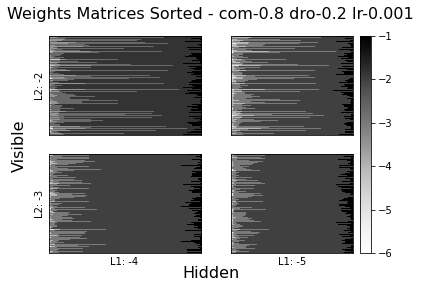

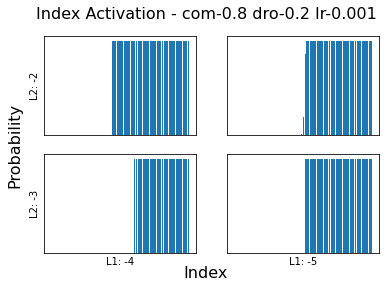

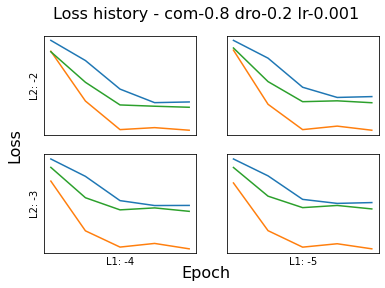

In [276]:
def test_model_reg_cof(trainingSet, order_variation, epochs = 500, compression = 0.8, batch_size = 20, reg_cof = [0.001, 0.01], dropout = 0.2, lr = 0.001, validation_split = 0.05, metrics = tf.keras.metrics.RootMeanSquaredError(), weight_sort="unit"):
    param_name = "- com-"+str(compression)+" dro-"+str(dropout)+ " lr-"+str(lr)
    
    fig_sorted, axes_sorted = plt.subplots(nrows=order_variation, ncols=order_variation)
    fig_sorted.suptitle('Weights Matrices Sorted '+param_name, fontsize=16)
    fig_sorted.subplots_adjust(hspace = .2, wspace = 0.2)

    fig_index, axes_index = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_index.suptitle("Index Activation "+param_name, fontsize = 16)

    fig_loss, axes_loss = plt.subplots(nrows=order_variation, ncols=order_variation, constrained_layout = False)
    fig_loss.suptitle("Loss history "+param_name, fontsize = 16)
    im = None
    im2=None
    for i in range(order_variation):

        for j in range(order_variation):
            model, model_history = train_model(
                trainingSet, epochs, 
                compression, batch_size, [reg_cof[0] / 10**i, reg_cof[1] / 10**j], 
                dropout, lr, validation_split, metrics)

            #bit_activation, weights_matrix, sorted_weights_matrix = weights_matrix_sorting(model)
            if weight_sort=="unit":
                bit_activation, weights_matrix, sort_matrix = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(sort_matrix,interpolation='nearest',cmap=cm.Greys)

            if weight_sort=="split":
                bit_activation, weights_matrix, mask_neg, mask_pos, neg, pos = weights_matrix_sorting(model, weight_sort=weight_sort)
                im = axes_sorted[i][j].imshow(mask_neg,interpolation='nearest',cmap=cm.Blues)
                im2 = axes_sorted[i][j].imshow(mask_pos,interpolation='nearest',cmap=cm.Reds)

            axes_sorted[i][j].set_aspect('auto')
            axes_sorted[i][j].xaxis.set_ticks([])
            axes_sorted[i][j].yaxis.set_ticks([])

            axes_index[i][j].bar(np.arange(len(bit_activation)), bit_activation)
            axes_index[i][j].xaxis.set_ticks([])
            axes_index[i][j].yaxis.set_ticks([])

            for metrics_ in list(model_history.history.keys())[1:]:
                axes_loss[i][j].plot(np.arange(0, epochs), model_history.history[metrics_], label=metrics_)
            axes_loss[i][j].xaxis.set_ticks([])
            axes_loss[i][j].yaxis.set_ticks([])

            if j == i:
                l2value = round(math.log(reg_cof[1] / 10**j,10))
                axes_sorted[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_index[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)
                axes_loss[j][0].set_ylabel("L2: {}".format(l2value),fontsize=10)

                
        axes_sorted[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
        axes_index[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
        axes_loss[order_variation-1][i].set_xlabel("L1: {}".format(round(math.log(reg_cof[0] / 10**i,10)-1)),fontsize=10) 
    if weight_sort=="unit":
        
        fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
    if weight_sort=="split":
        
        cbpos = fig_sorted.colorbar(im, ax=axes_sorted[:, order_variation-1])
        cbneg = fig_sorted.colorbar(im2, ax=axes_sorted[:, order_variation-1])



        #plt.setp(axes_sorted[:,i], ylabel = "L1 {}".format(int(math.log(reg_cof[0] / 10**i,10)-1)))
    fig_sorted.text(0.5, 0.04, 'Hidden', ha='center', fontsize = 16)
    fig_sorted.text(0.04, 0.5, 'Visible', va='center', rotation='vertical', fontsize = 16)
    
    fig_index.text(0.5, 0.04, 'Index', ha='center', fontsize = 16)
    fig_index.text(0.04, 0.5, 'Probability', va='center', rotation='vertical', fontsize = 16)
    
    fig_loss.text(0.5, 0.04, 'Epoch', ha='center', fontsize = 16)
    fig_loss.text(0.04, 0.5, 'Loss', va='center', rotation='vertical', fontsize = 16)

    fig_sorted.savefig(utg.create_plot_path("Weights Sorted Comparision{}.png".format(param_name)))
    fig_index.savefig(utg.create_plot_path("Index Sorted Comparision{}.png".format(param_name)))
    fig_loss.savefig(utg.create_plot_path("Loss History Comparision{}.png".format(param_name)))

    plt.show()

test_model_reg_cof(tmptrain, 2, epochs = 5, weight_sort="unit")



[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


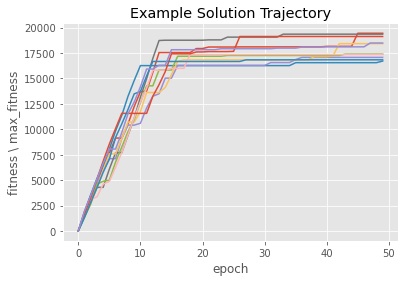

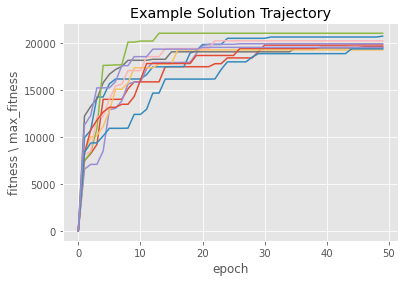

In [5]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50 ,"to_delete.png")
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model1 )

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


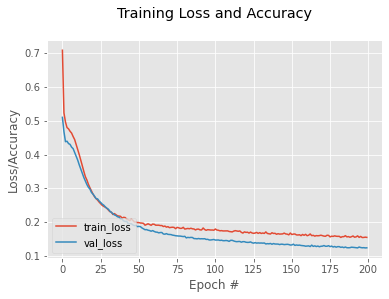

In [15]:

model2 = shallowNet.build(
    input_shape=knapSack.Size, 
    reg_cof= reg_cof, 
    lr = lr, 
    dropout= dropout, 
    compression=compression
)

H2 = model2.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H2, "to_delete.png", epochs)

In [16]:
model3 = utm.add_layer_to_model(model2, compression, dropout, reg_cof,lr,True )

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_4 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_3 (DenseTran (None, 100)               818

[INFO]: Loss plot was saved in the directory:  saved_plots\to_delete.png


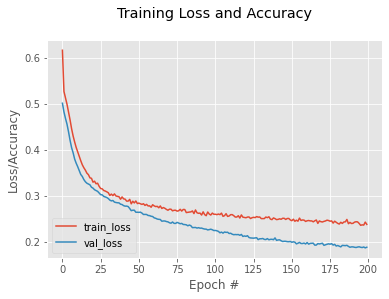

In [17]:
H3 = model3.fit(
    trainY2, trainY2, 
    validation_split = 0.05,
    epochs=epochs, 
    batch_size=batch_size, 
    shuffle=True,
    verbose=0)
utp.plot_model_loss(H3, "to_delete.png", epochs)

[INFO]: number of convoluted layers is equal to:  2
[INFO]: Weights of model were saved in the directory:  saved_plots\to_delete.png


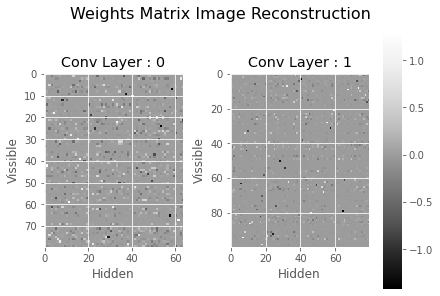

In [18]:
utp.plot_weights_model(model3, "to_delete.png")


[INFO]: Evolution model plot was saved in the directory:  saved_plots\to_delte.png


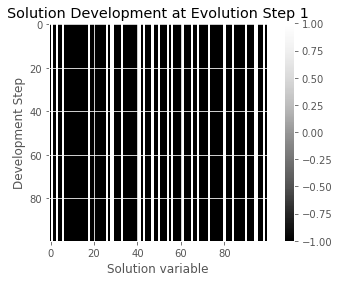

In [31]:
utp.plot_evolution_model(model3, trainY1, "to_delte.png", learning_steps=100)

[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png
[INFO]: Fitness development phase plot was saved in the directory:  saved_plots\to_delete.png


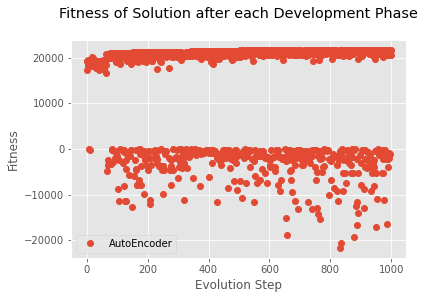

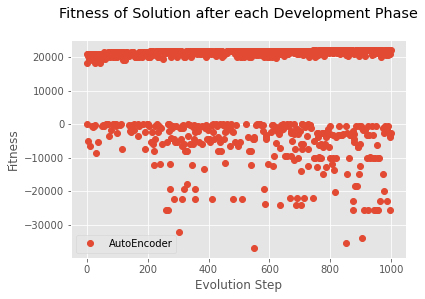

In [20]:
utp.plot_fitness_development_phase(model1, trainY1, "to_delete.png")
utp.plot_fitness_development_phase(model3, trainY1, "to_delete.png")

[INFO]: Trajectory evoultion plot was saved in the directory:  saved_plots\to_delete.png


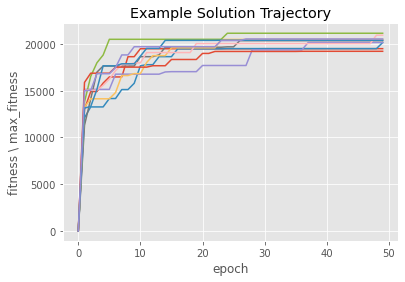

In [23]:
utp.plot_trajectory_evolution(knapSack.Size, 10, 50, "to_delete.png", model3 )

In [32]:
modeltmp = utg.load_models(3)[0]

In [35]:
#utp.plot_weights_model(modeltmp, "to_delete.png")
np.shape(modeltmp.layers[-1].get_weights()[1])

(100, 80)

In [36]:
modeltmp.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                5184      
_________________________________________________________________
dense_transpose_2 (DenseTran (None, 80)                5264      
_________________________________________________________________
dense_transpose_1 (DenseTran (None, 100)               8180

In [213]:
arr = np.array([-0.1, 0.001,-0.001, 0.1])

def matrix_row_sort(x):
    def pushZerosToEnd(arr): 
        count = 0 # Count of non-zero elements 
        n = len(arr)
        for i in range(n): 
            if arr[i] != 0: 
                arr[count] = arr[i] 
                count+=1

        while count < n: 
            arr[count] = 0
            count += 1
        return arr
    
    def pushZerosToBegining(arr): 
        count = 0 # Count of non-zero elements 
        tmp = []
        count_zeros =0
        for i in arr.tolist(): 
            if i != 0: 
                tmp.append(i)
            else:
                count_zeros+=1
        return np.concatenate((np.zeros(count_zeros), np.asarray(tmp)), axis = None)
    pos = []
    neg = []
    for i in x:
        if i>0:
            pos.append(round(math.log(i,10)))
            neg.append(0)
        else:
            neg.append(round(math.log(-i,10)))
            pos.append(0)
    return pushZerosToEnd(-np.sort(-np.asarray(neg))), pushZerosToBegining(np.sort(np.asarray(pos)))
matrix_row_sort(arr)

(array([-1, -3,  0,  0]), array([ 0.,  0., -3., -1.]))

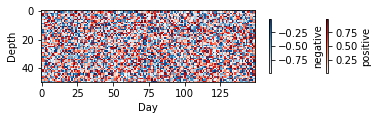

masked_array(
  data=[[0.7323806941614195, 0.4528978363832279, --, ..., --, --, --],
        [--, --, --, ..., --, 0.5569275944515162, 0.6746960234954373],
        [0.5322079230309231, 0.8206470033154245, 0.5443411179418169, ...,
         0.5679450018565666, --, 0.7799216623430807],
        ...,
        [0.9357578859068183, --, 0.3304484486132069, ..., --, --,
         0.9611600196454786],
        [--, 0.2626391297899797, 0.49089214230737666, ..., --, --,
         0.703404817801816],
        [--, --, --, ..., 0.4709529071744083, 0.33703126187079446,
         0.9775875358211044]],
  mask=[[False, False,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, False, False],
        [False, False, False, ..., False,  True, False],
        ...,
        [False,  True, False, ...,  True,  True, False],
        [ True, False, False, ...,  True,  True, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20)

In [134]:
tgp

array([2, 0, 0, 0])

In [124]:
arr = np.array([-2,  0,  0,  1])

    
pushZerosToBegining(arr)

array([ 0.,  0., -2.,  1.])